# Analysis of Attention and HMM/DNN results


## Setup

In [559]:
import speechbrain as sb
from speechbrain.utils import edit_distance
import speechbrain.dataio.wer as wer_io
import numpy as np
import pathlib
import re
import matplotlib.pyplot as plt
import cycler
import statistics
import bisect
import scipy.stats
import operator

In [7]:
sty_cycle = cycler.cycler(c=['tab:blue','tab:orange','tab:green']) + \
            cycler.cycler(ls=["-",":","--"])
sty_cycle = iter(sty_cycle)

In [182]:
def load_text(path):
    texts = {}
    with open(path) as fin:
        for line in fin:
            uttid, *text = line.strip().split()
            # HACK!
            uttid = uttid.replace("é", "e")
            texts[uttid] = text
    return texts

In [337]:
def load_text_spm(path):
    texts = {}
    with open(path) as fin:
        for line in fin:
            uttid, *text = line.strip().split()
            # HACK!
            uttid = uttid.replace("é", "e")
            text = "".join(text)
            if text[0] =="▁":
                text = text[1:]
            text = text.replace("▁", " ")
            texts[uttid] = text.split()
    return texts

In [329]:
def load_chars(path):
    texts = {}
    with open(path) as fin:
        for line in fin:
            uttid, *text = line.strip().split()
            # HACK!
            uttid = uttid.replace("é", "e")
            texts[uttid] = " ".join(text)
    return texts

In [338]:
def load_chars_spm(path):
    texts = {}
    with open(path) as fin:
        for line in fin:
            uttid, *text = line.strip().split()
            # HACK!
            uttid = uttid.replace("é", "e")
            text = "".join(text)
            if text[0] =="▁":
                text = text[1:]
            text = text.replace("▁", " ")
            texts[uttid] = text
    return texts

In [49]:
def split_to_quantiles(textdict, n):
    quantile_cutoffs = statistics.quantiles((len(v) for v in textdict.values()), n=n)
    quantiles = [{} for _ in range(n)]
    for uttid, text in textdict.items():
        v = len(text)
        q_index = bisect.bisect_left(quantile_cutoffs, v)
        quantiles[q_index][uttid] = text
    quantile_strings = [f"l <= {quantile_cutoffs[0]}"] + \
            [f"{quantile_cutoffs[i-1]} < l <= {quantile_cutoffs[i]}" for i in range(1, n-1)] + \
            [f"{quantile_cutoffs[n-2]} < l"]
    return quantiles, quantile_strings

In [168]:
def wer_by_quantiles(ref_quantiles, cutoffs, hyp_dict):
    for ref_quantile, name in zip(ref_quantiles, cutoffs):
        print(name)
        quantile_details = edit_distance.wer_details_by_utterance(ref_quantile, hyp_dict)
        quantile_summary = edit_distance.wer_summary(quantile_details)
        wer_io.print_wer_summary(quantile_summary)

In [187]:
def append_cers(wer_details):
    for details in wer_details:
        ref_chars = (" ".join(details['ref_tokens']))
        hyp_chars = (" ".join(details['hyp_tokens']))
        ops = edit_distance.op_table(ref_chars, hyp_chars)
        cer = edit_distance.count_ops(ops)
        details['CER'] = cer

In [706]:
def analyse_basic(ref, hmm, aed, utt2spk):

    top_k_utts = 250
    top_k_spks = 5
    hmm_details = edit_distance.wer_details_by_utterance(
        ref, 
        hmm, 
        compute_alignments=True,
        scoring_mode="strict"
    )
    hmm_by_spk = edit_distance.wer_details_by_speaker(
        hmm_details,
        utt2spk,
    )
    hmm_summary = edit_distance.wer_summary(hmm_details)
    hmm_top_wer, hmm_top_empty = edit_distance.top_wer_utts(hmm_details,top_k=top_k_utts)
    hmm_top_wer_spk = edit_distance.top_wer_spks(hmm_by_spk, top_k=top_k_spks)

    aed_details = edit_distance.wer_details_by_utterance(
        ref, 
        aed, 
        compute_alignments=True,
        scoring_mode="strict"
    )
    aed_by_spk = edit_distance.wer_details_by_speaker(
        aed_details,
        utt2spk,
    )
    aed_summary = edit_distance.wer_summary(aed_details)
    aed_top_wer, aed_top_empty  = edit_distance.top_wer_utts(aed_details,top_k=top_k_utts)
    aed_top_wer_spk = edit_distance.top_wer_spks(aed_by_spk, top_k=top_k_spks)
    
    print("HMM Summary:")
    wer_io.print_wer_summary(hmm_summary)
    wer_io._print_top_wer_spks(hmm_top_wer_spk)
    #wer_io._print_top_wer_utts(hmm_top_wer,hmm_top_empty)
    print("")
    print("AED Summary:")
    wer_io.print_wer_summary(aed_summary)
    wer_io._print_top_wer_spks(aed_top_wer_spk)
    #wer_io._print_top_wer_utts(aed_top_wer,aed_top_empty)
    print("")
    
    print("WER difference:")
    print(aed_summary['WER']-hmm_summary['WER'], "percentage points")
    print((aed_summary['WER']-hmm_summary['WER']) *100 / aed_summary['WER'], "% relative wer (relative to AED)" )
    delta = hmm_summary['num_edits']-aed_summary['num_edits']
    print("That leaves an edit delta of", hmm_summary['num_edits']-aed_summary['num_edits'])
    print("Which is", delta / len(hmm_details), "delta per utterance")
    print("")
    
    hmm_top_wer_uttids = list(map(lambda x: x['key'], hmm_top_wer))
    aed_top_wer_uttids = list(map(lambda x: x['key'], aed_top_wer))
    num_in_common = sum(1 for uttid in aed_top_wer_uttids if uttid in hmm_top_wer_uttids)
    print(num_in_common, "utts in common")
    print("out of", top_k_utts, "top WER utterances")
    print("That is", num_in_common/top_k_utts*100., "%")
    print()

    hmm_top_wer_spkids = list(map(lambda x: x['speaker'], hmm_top_wer_spk))
    aed_top_wer_spkids = list(map(lambda x: x['speaker'], aed_top_wer_spk))
    num_in_common_spk = sum(1 for spkid in aed_top_wer_spkids if spkid in hmm_top_wer_spkids)
    print(num_in_common_spk, "speakers in common")
    print("out of", top_k_spks, "top WER speakers")
    print("That is", num_in_common_spk/top_k_spks*100., "%")
    print("Are the top WER speakers the same?")
    print("HMM:", hmm_top_wer_spkids)
    print("AED:", aed_top_wer_spkids)
    print()
    
    n_quantiles = 2
    ref_quantiles, cutoffs = split_to_quantiles(ref, n=n_quantiles)
    print(f"Reference text divided to {n_quantiles} quantiles (equal parts) by utterance length:")
    print(cutoffs)
    print("HMM WER by quantiles:")
    wer_by_quantiles(ref_quantiles, cutoffs, hmm)
    print("AED WER by quantiles:")
    wer_by_quantiles(ref_quantiles, cutoffs, aed)
    print()
    
    cross_details = edit_distance.wer_details_by_utterance( 
    hmm,
    aed,
    compute_alignments=True,
    scoring_mode="strict"
    )

    
    
    cross_summary = edit_distance.wer_summary(cross_details)
    cross_top_wer, cross_top_empty = edit_distance.top_wer_utts(cross_details,top_k=5)
    print("Cross Summary (HMM as ref):")
    wer_io.print_wer_summary(cross_summary)
    print("Relative Cross WER:")
    print(cross_summary['WER']/aed_summary['WER']*100)
    #print("Highest differences highlighted (HMM as REF, AED as HYP):")
    #wer_io.print_alignments(cross_top_wer)
    
    print()
    uttid_and_delta = []
    for hmm_detail, aed_detail in zip(hmm_details, aed_details):
        assert hmm_detail['key'] == aed_detail['key']
        delta = hmm_detail['num_edits'] - aed_detail['num_edits']
        uttid_and_delta.append({'key': hmm_detail['key'],
                               'delta': delta,
                               'hmm_detail': hmm_detail,
                               'aed_detail': aed_detail})
    uttid_and_delta.sort(key=lambda x: x['delta'])
    print("HMM wins:")
    for detail in uttid_and_delta[:3]:
        print(detail['key'], "DELTA:", detail['delta'])
        print("REF:", " ".join(detail['aed_detail']['ref_tokens']))
        print("AED:", " ".join(detail['aed_detail']['hyp_tokens']))
        print("HMM:", " ".join(detail['hmm_detail']['hyp_tokens']))
        
    print("AED wins:")
    for detail in uttid_and_delta[-3:]:
        print(detail['key'], "DELTA:", detail['delta'])
        print("REF:", " ".join(detail['aed_detail']['ref_tokens']))
        print("AED:", " ".join(detail['aed_detail']['hyp_tokens']))
        print("HMM:", " ".join(detail['hmm_detail']['hyp_tokens']))
        
    num_hmm_wins = sum(1 if ud['delta'] <0 else 0 for ud in uttid_and_delta)
    num_aed_wins = sum(1 if ud['delta'] >0 else 0 for ud in uttid_and_delta)
    num_ties = len(uttid_and_delta) - num_hmm_wins - num_aed_wins
    print()
    print("Percentage of HMM wins:", num_hmm_wins / len(uttid_and_delta) *100.)
    print("Percentage of AED wins:", num_aed_wins / len(uttid_and_delta) *100.)
    print("Percentage of ties:", num_ties / len(uttid_and_delta) *100.)
        
    print()
    print("Kendall's tau (-1,1), a measure of rank correlation")
    print("By WER of Utterances:")
    wergetter = operator.itemgetter("WER")
    kt_utt = scipy.stats.kendalltau(list(map(wergetter, hmm_details)), list(map(wergetter, aed_details)))
    print("Statistic:", f"{kt_utt[0]:.2f}", "and p-value:", kt_utt[1])
    
    print("By WER for Speakers:")
    wergetter = operator.itemgetter("WER")
    kt_spk = scipy.stats.kendalltau(list(map(wergetter, hmm_by_spk)), list(map(wergetter, aed_by_spk)))
    print("Statistic:", f"{kt_spk[0]:.2f}", "and p-value:", kt_spk[1])
    print()
    print(f"Copy to Tex: |  & {kt_utt[0]:.2f}  & {kt_spk[0]:.2f} ")
    print()

In [295]:
def analyse_deltas_multi(refs, hmms, aeds):
    hmm_details = []
    aed_details = []
    for ref, hmm in zip(refs, hmms):
        hmm_details.append(edit_distance.wer_details_by_utterance(
            ref, 
            hmm, 
            compute_alignments=True,
            scoring_mode="strict"
        ))
    for ref, aed in zip(refs, aeds):
        aed_details.append(edit_distance.wer_details_by_utterance(
            ref, 
            aed, 
            compute_alignments=True,
            scoring_mode="strict"
        ))
    uttid_and_deltas = []
    for hmm_variants, aed_variants in zip(zip(*hmm_details), zip(*aed_details)):
        edit_deltas = []
        rate_deltas = []
        for hmm_variant, aed_variant in zip(hmm_variants, aed_variants):
            assert hmm_variant['key'] == aed_variant['key']
            edit_delta = hmm_variant['num_edits'] - aed_variant['num_edits']
            edit_deltas.append(edit_delta)
            rate_delta = hmm_variant['WER'] - aed_variant['WER']
            rate_deltas.append(rate_delta)
        uttid_and_deltas.append({'key': hmm_variants[0]['key'],
                               'edit_deltas': edit_deltas,
                                'rate_deltas': rate_deltas,
                               'hmm_variants': hmm_variants,
                               'aed_variants': aed_variants})
    uttid_and_deltas.sort(key=lambda x: x['edit_deltas'][0])
    return uttid_and_deltas

In [398]:
from collections import Counter
def analyse_edit_ops(ref, hmm, aed):
    hmm_ops = Counter()
    aed_ops = Counter()
    cross_ops = Counter()
    for uttid, reftext in ref.items():
        hmmtext = hmm[uttid]
        aedtext = aed[uttid]
        hmm_ali = edit_distance.alignment(edit_distance.op_table(reftext, hmmtext))
        hmm_ops += Counter(
            (edit, reftext[ri] if ri is not None else "<eps>", hmmtext[hi] if hi is not None else "<eps>") 
            for edit, ri, hi in hmm_ali)
        aed_ali = edit_distance.alignment(edit_distance.op_table(reftext, aedtext))
        aed_ops += Counter(
            (edit, reftext[ri] if ri is not None else "<eps>", aedtext[hi] if hi is not None else "<eps>") 
            for edit, ri, hi in aed_ali)
        cross_ali = edit_distance.alignment(edit_distance.op_table(hmmtext, aedtext))
        cross_ops += Counter(
            (edit, hmmtext[ri] if ri is not None else "<eps>", aedtext[hi] if hi is not None else "<eps>") 
            for edit, ri, hi in cross_ali)
    return hmm_ops, aed_ops, cross_ops

In [402]:
def analyse_edit_streaks(ref, hmm, aed):
    hmm_counter = Counter()
    aed_counter = Counter()
    for uttid, reftext in ref.items():
        hmmtext = hmm[uttid]
        aedtext = aed[uttid]
        hmm_ali = edit_distance.alignment(edit_distance.op_table(reftext, hmmtext))
        aed_ali = edit_distance.alignment(edit_distance.op_table(reftext, aedtext))       
        hmm_streak = 0
        for edit, ri, hi in hmm_ali:
            if edit == "=":
                if hmm_streak > 0:
                    hmm_counter[hmm_streak]+=1
                hmm_streak = 0
            else:
                hmm_streak+=1
        if hmm_streak > 0:
            hmm_counter[hmm_streak]+=1
        aed_streak = 0
        for edit, ri, hi in aed_ali:
            if edit == "=":
                if aed_streak > 0:
                    aed_counter[aed_streak]+=1
                aed_streak = 0
            else:
                aed_streak+=1
        if aed_streak > 0:
            aed_counter[aed_streak]+=1
    return hmm_counter, aed_counter

## Finnish Train20

In [691]:
#PARL TEST 16
test_ref_path = "fin-train20/speechbrain_2015-2020-kevat/exp/mtl-am/New-CRDNN-J-contd/2602-2328units/decode_parl-test-all_sb-vocab-train20-varikn.d0.0001-bpe1750/scoring_kaldi/test_filt.txt"
hmm_crdnn_trans_hyp_path = "fin-train20/speechbrain_2015-2020-kevat/exp/mtl-am/New-CRDNN-J-contd/2602-2328units/decode_parl-test-all_sb-vocab-train20-varikn.d0.0001-bpe1750/scoring_kaldi/penalty_0.5/10.txt"
aed_crdnn_trans_hyp_path = "fin-train20/speechbrain_2015-2020-kevat_e2e/exp/MWER/CRDNN-E-contd/2602-1750units/text_test-all_beam4_cov3.0_eos1.2_temp2.0_noattnshift.txt"
hmm_crdnn_lm_hyp_path = "fin-train20/speechbrain_2015-2020-kevat/exp/mtl-am/New-CRDNN-J-contd/2602-2328units/decode_parl-test-all_sb-vocab-parl30M-varikn.d0.0001-bpe1750/100best-outputs/scoring/rescored_text.lmwt9.trafo_30M"
aed_crdnn_lm_hyp_path = "fin-train20/speechbrain_2015-2020-kevat_e2e/exp/CRDNN-E-contd-MWER_trafo-D/2602_2224_1750/text_test-all_beam24_cov3.0_eos1.17_temp1.5_noattnshift_lm0.3.txt"
fshmm_crdnn_trans_hyp_path = "fin-train20/speechbrain_2015-2020-kevat/exp/lfmmi-am/New-CRDNN-J/2602-1128units/decode_parl-test-all_sb-vocab-train20-varikn.d0.0001-bpe1750/scoring_kaldi/penalty_0.0/9.txt"
fshmm_crdnn_lm_hyp_path = "fin-train20/speechbrain_2015-2020-kevat/exp/lfmmi-am/New-CRDNN-J/2602-1128units/decode_parl-test-all_sb-vocab-parl30M-varikn.d0.0001-bpe1750/100best-outputs/scoring/rescored_text.lmwt7.trafo_30M"
hmm_w2v2_trans_hyp_path = "fin-train20/speechbrain_2015-2020-kevat/exp/mtl-am/New-W2V2-F/2602-2480units/decode_parl-test-all_sb-vocab-train20-varikn.d0.0001-bpe1750/scoring_kaldi/penalty_0.5/10.txt"
aed_w2v2_trans_hyp_path = "fin-train20/speechbrain_2015-2020-kevat_e2e/exp/MWER/W2V2-F/2602-1750units/text_test-all_beam4_cov3.0_eos1.3_temp2.0_noattnshift.txt"
hmm_w2v2_lm_hyp_path = "fin-train20/speechbrain_2015-2020-kevat/exp/mtl-am/New-W2V2-F/2602-2480units/decode_parl-test-all_sb-vocab-parl30M-varikn.d0.0001-bpe1750/100best-outputs/scoring/rescored_text.lmwt11.trafo_30M"
aed_w2v2_lm_hyp_path = "fin-train20/speechbrain_2015-2020-kevat_e2e/exp/W2V2_trafo-D/2602_2224_1750/text_test-all_beam40_cov3.0_eos1.3_temp2.0_noattnshift_lm0.3.txt"



test_ref = load_text(test_ref_path)
test_ref_char = load_chars(test_ref_path)
hmm_crdnn_trans_hyp = load_text(hmm_crdnn_trans_hyp_path)
hmm_crdnn_trans_hyp_char = load_chars(hmm_crdnn_trans_hyp_path)
hmm_crdnn_lm_hyp = load_text_spm(hmm_crdnn_lm_hyp_path, )
hmm_crdnn_lm_hyp_char = load_chars_spm(hmm_crdnn_lm_hyp_path)
hmm_w2v2_trans_hyp = load_text(hmm_w2v2_trans_hyp_path)
hmm_w2v2_trans_hyp_char = load_chars(hmm_w2v2_trans_hyp_path)
hmm_w2v2_lm_hyp = load_text_spm(hmm_w2v2_lm_hyp_path)
hmm_w2v2_lm_hyp_char = load_chars_spm(hmm_w2v2_lm_hyp_path)

aed_crdnn_trans_hyp = load_text(aed_crdnn_trans_hyp_path)
aed_crdnn_trans_hyp_char = load_chars(aed_crdnn_trans_hyp_path)
aed_crdnn_lm_hyp = load_text(aed_crdnn_lm_hyp_path)
aed_crdnn_lm_hyp_char = load_chars(aed_crdnn_lm_hyp_path)
aed_w2v2_trans_hyp = load_text(aed_w2v2_trans_hyp_path)
aed_w2v2_trans_hyp_char = load_chars(aed_w2v2_trans_hyp_path)
aed_w2v2_lm_hyp = load_text(aed_w2v2_lm_hyp_path)
aed_w2v2_lm_hyp_char = load_chars(aed_w2v2_lm_hyp_path)

fshmm_crdnn_trans_hyp = load_text(fshmm_crdnn_trans_hyp_path)
fshmm_crdnn_trans_hyp_char = load_chars(fshmm_crdnn_trans_hyp_path)
fshmm_crdnn_lm_hyp = load_text_spm(fshmm_crdnn_lm_hyp_path, )
fshmm_crdnn_lm_hyp_char = load_chars_spm(fshmm_crdnn_lm_hyp_path)




utt2spk = {uttid: "-".join(uttid.split("-")[:-1]) for uttid in test_ref}

In [677]:
#PARL TEST 2020
test_ref_path = "fin-train20/speechbrain_2015-2020-kevat/exp/mtl-am/New-CRDNN-J-contd/2602-2328units/decode_parl-test2020_sb-vocab-train20-varikn.d0.0001-bpe1750/scoring_kaldi/test_filt.txt"
hmm_crdnn_trans_hyp_path = "fin-train20/speechbrain_2015-2020-kevat/exp/mtl-am/New-CRDNN-J-contd/2602-2328units/decode_parl-test2020_sb-vocab-train20-varikn.d0.0001-bpe1750/scoring_kaldi/penalty_0.5/10.txt"
aed_crdnn_trans_hyp_path = "fin-train20/speechbrain_2015-2020-kevat_e2e/exp/MWER/CRDNN-E-contd/2602-1750units/text_test2021_beam4_cov3.0_eos1.3_temp2.0_noattnshift.txt"
hmm_crdnn_lm_hyp_path = "fin-train20/speechbrain_2015-2020-kevat/exp/mtl-am/New-CRDNN-J-contd/2602-2328units/decode_parl-test2020_sb-vocab-parl30M-varikn.d0.0001-bpe1750/100best-outputs/scoring/rescored_text.lmwt9.trafo_30M"
aed_crdnn_lm_hyp_path = "fin-train20/speechbrain_2015-2020-kevat_e2e/exp/CRDNN-E-contd-MWER_trafo-D/2602_2224_1750/text_test2021_beam24_cov3.0_eos1.17_temp1.5_noattnshift_lm0.3.txt"
fshmm_crdnn_trans_hyp_path = "fin-train20/speechbrain_2015-2020-kevat/exp/lfmmi-am/New-CRDNN-J/2602-1128units/decode_parl-test2020_sb-vocab-train20-varikn.d0.0001-bpe1750/scoring_kaldi/penalty_0.0/9.txt"
fshmm_crdnn_lm_hyp_path = "fin-train20/speechbrain_2015-2020-kevat/exp/lfmmi-am/New-CRDNN-J/2602-1128units/decode_parl-test2020_sb-vocab-parl30M-varikn.d0.0001-bpe1750/100best-outputs/scoring/rescored_text.lmwt7.trafo_30M"
hmm_w2v2_trans_hyp_path = "fin-train20/speechbrain_2015-2020-kevat/exp/mtl-am/New-W2V2-F/2602-2480units/decode_parl-test2020_sb-vocab-train20-varikn.d0.0001-bpe1750/scoring_kaldi/penalty_0.5/10.txt"
aed_w2v2_trans_hyp_path = "fin-train20/speechbrain_2015-2020-kevat_e2e/exp/MWER/W2V2-F/2602-1750units/text_test2021_beam4_cov3.0_eos1.3_temp2.0_noattnshift.txt"
hmm_w2v2_lm_hyp_path = "fin-train20/speechbrain_2015-2020-kevat/exp/mtl-am/New-W2V2-F/2602-2480units/decode_parl-test2020_sb-vocab-parl30M-varikn.d0.0001-bpe1750/100best-outputs/scoring/rescored_text.lmwt11.trafo_30M"
aed_w2v2_lm_hyp_path = "fin-train20/speechbrain_2015-2020-kevat_e2e/exp/W2V2_trafo-D/2602_2224_1750/text_test2021_beam40_cov3.0_eos1.3_temp2.0_noattnshift_lm0.3.txt"



test_ref = load_text(test_ref_path)
test_ref_char = load_chars(test_ref_path)
hmm_crdnn_trans_hyp = load_text(hmm_crdnn_trans_hyp_path)
hmm_crdnn_trans_hyp_char = load_chars(hmm_crdnn_trans_hyp_path)
hmm_crdnn_lm_hyp = load_text_spm(hmm_crdnn_lm_hyp_path, )
hmm_crdnn_lm_hyp_char = load_chars_spm(hmm_crdnn_lm_hyp_path)
hmm_w2v2_trans_hyp = load_text(hmm_w2v2_trans_hyp_path)
hmm_w2v2_trans_hyp_char = load_chars(hmm_w2v2_trans_hyp_path)
hmm_w2v2_lm_hyp = load_text_spm(hmm_w2v2_lm_hyp_path)
hmm_w2v2_lm_hyp_char = load_chars_spm(hmm_w2v2_lm_hyp_path)

aed_crdnn_trans_hyp = load_text(aed_crdnn_trans_hyp_path)
aed_crdnn_trans_hyp_char = load_chars(aed_crdnn_trans_hyp_path)
aed_crdnn_lm_hyp = load_text(aed_crdnn_lm_hyp_path)
aed_crdnn_lm_hyp_char = load_chars(aed_crdnn_lm_hyp_path)
aed_w2v2_trans_hyp = load_text(aed_w2v2_trans_hyp_path)
aed_w2v2_trans_hyp_char = load_chars(aed_w2v2_trans_hyp_path)
aed_w2v2_lm_hyp = load_text(aed_w2v2_lm_hyp_path)
aed_w2v2_lm_hyp_char = load_chars(aed_w2v2_lm_hyp_path)

fshmm_crdnn_trans_hyp = load_text(fshmm_crdnn_trans_hyp_path)
fshmm_crdnn_trans_hyp_char = load_chars(fshmm_crdnn_trans_hyp_path)
fshmm_crdnn_lm_hyp = load_text_spm(fshmm_crdnn_lm_hyp_path, )
fshmm_crdnn_lm_hyp_char = load_chars_spm(fshmm_crdnn_lm_hyp_path)




utt2spk = {uttid: uttid.split("-")[0] for uttid in test_ref}

In [701]:
#LIBRI TEST CLEAN:

test_ref_path = "librispeech/exp/chain/New-CRDNN-FF-10-fixed-contd/2602-2256units/decode_test_clean_bpe.5000.varikn_acwt1.0/scoring_kaldi/test_filt.txt"
hmm_crdnn_trans_hyp_path = "librispeech/exp/chain/New-CRDNN-FF-10-fixed-contd/2602-2256units/decode_test_clean_bpe.5000.varikn_acwt1.0/scoring_kaldi/penalty_0.5/10.txt"
aed_crdnn_trans_hyp_path = "librispeech/exp/attention/CRDNN-FF-10-contd/2602-5000units/text_test_clean_beam8_cov3.0_eos1.3_temp1.5_noattnshift.txt"
hmm_crdnn_lm_hyp_path = "librispeech/exp/chain/New-CRDNN-FF-10-fixed-contd/2602-2256units/decode_test_clean_4gram_char_rescored_acwt1.0/scoring_kaldi/penalty_0.0/12.txt"
fshmm_crdnn_lm_hyp_path = "librispeech/exp/chain_e2e/New-CRDNN-FF-10-contd/2602-1322units/decode_test_clean_4gram_char_rescored_acwt1.0/scoring_kaldi/penalty_0.5/10.txt"
fshmm_crdnn_trans_hyp_path = "librispeech/exp/chain_e2e/New-CRDNN-FF-10-contd/2602-1322units/decode_test_clean_bpe.5000.varikn_acwt1.0/scoring_kaldi/penalty_0.5/9.txt"
hmm_w2v2_trans_hyp_path = "librispeech/exp/chain/New-W2V2-F/2602-2240units/decode_test_clean_bpe.5000.varikn_acwt1.0/scoring_kaldi/penalty_0.5/10.txt"
aed_w2v2_trans_hyp_path = "librispeech/exp/attention/New-W2V2-F/2602-5000units/text_test_clean_beam12_cov3.0_eos1.3_temp1.0_noattnshift.txt"
hmm_w2v2_lm_hyp_path = ""
aed_w2v2_lm_hyp_path = ""



test_ref = load_text(test_ref_path)
test_ref_char = load_chars(test_ref_path)
hmm_crdnn_trans_hyp = load_text(hmm_crdnn_trans_hyp_path)
hmm_crdnn_trans_hyp_char = load_chars(hmm_crdnn_trans_hyp_path)
hmm_crdnn_lm_hyp = load_text(hmm_crdnn_lm_hyp_path )
hmm_crdnn_lm_hyp_char = load_chars(hmm_crdnn_lm_hyp_path)
hmm_w2v2_trans_hyp = load_text(hmm_w2v2_trans_hyp_path)
hmm_w2v2_trans_hyp_char = load_chars(hmm_w2v2_trans_hyp_path)
#hmm_w2v2_lm_hyp = load_text_spm(hmm_w2v2_lm_hyp_path)
#hmm_w2v2_lm_hyp_char = load_chars_spm(hmm_w2v2_lm_hyp_path)

aed_crdnn_trans_hyp = load_text(aed_crdnn_trans_hyp_path)
aed_crdnn_trans_hyp_char = load_chars(aed_crdnn_trans_hyp_path)
aed_w2v2_trans_hyp = load_text(aed_w2v2_trans_hyp_path)
aed_w2v2_trans_hyp_char = load_chars(aed_w2v2_trans_hyp_path)
#aed_w2v2_lm_hyp = load_text(aed_w2v2_lm_hyp_path)
#aed_w2v2_lm_hyp_char = load_chars(aed_w2v2_lm_hyp_path)

fshmm_crdnn_trans_hyp = load_text(fshmm_crdnn_trans_hyp_path)
fshmm_crdnn_trans_hyp_char = load_chars(fshmm_crdnn_trans_hyp_path)
fshmm_crdnn_lm_hyp = load_text(fshmm_crdnn_lm_hyp_path, )
fshmm_crdnn_lm_hyp_char = load_chars(fshmm_crdnn_lm_hyp_path)

utt2spk = {uttid: "-".join(uttid.split("-")[:-1]) for uttid in test_ref}

In [683]:
#LIBRI TEST OTHER:

test_ref_path = "librispeech/exp/chain/New-CRDNN-FF-10-fixed-contd/2602-2256units/decode_test_other_bpe.5000.varikn_acwt1.0/scoring_kaldi/test_filt.txt"
hmm_crdnn_trans_hyp_path = "librispeech/exp/chain/New-CRDNN-FF-10-fixed-contd/2602-2256units/decode_test_other_bpe.5000.varikn_acwt1.0/scoring_kaldi/penalty_0.0/13.txt"
aed_crdnn_trans_hyp_path = "librispeech/exp/attention/CRDNN-FF-10-contd/2602-5000units/text_test_other_beam24_cov3.0_eos1.3_temp1.5_noattnshift.txt"
hmm_crdnn_lm_hyp_path = "librispeech/exp/chain/New-CRDNN-FF-10-fixed-contd/2602-2256units/decode_test_other_4gram_char_rescored_acwt1.0/scoring_kaldi/penalty_0.0/14.txt"
fshmm_crdnn_lm_hyp_path = "librispeech/exp/chain_e2e/New-CRDNN-FF-10-contd/2602-1322units/decode_test_other_4gram_char_rescored_acwt1.0/scoring_kaldi/penalty_0.5/12.txt"
fshmm_crdnn_trans_hyp_path = "librispeech/exp/chain_e2e/New-CRDNN-FF-10-contd/2602-1322units/decode_test_other_bpe.5000.varikn_acwt1.0/scoring_kaldi/penalty_0.0/12.txt"
hmm_w2v2_trans_hyp_path = "librispeech/exp/chain/New-W2V2-F/2602-2240units/decode_test_other_bpe.5000.varikn_acwt1.0/scoring_kaldi/penalty_0.5/11.txt"
aed_w2v2_trans_hyp_path = "librispeech/exp/attention/New-W2V2-F/2602-5000units/text_test_other_beam12_cov3.0_eos1.3_temp1.0_noattnshift.txt"
hmm_w2v2_lm_hyp_path = ""
aed_w2v2_lm_hyp_path = ""



test_ref = load_text(test_ref_path)
test_ref_char = load_chars(test_ref_path)
hmm_crdnn_trans_hyp = load_text(hmm_crdnn_trans_hyp_path)
hmm_crdnn_trans_hyp_char = load_chars(hmm_crdnn_trans_hyp_path)
hmm_crdnn_lm_hyp = load_text(hmm_crdnn_lm_hyp_path )
hmm_crdnn_lm_hyp_char = load_chars(hmm_crdnn_lm_hyp_path)
hmm_w2v2_trans_hyp = load_text(hmm_w2v2_trans_hyp_path)
hmm_w2v2_trans_hyp_char = load_chars(hmm_w2v2_trans_hyp_path)
#hmm_w2v2_lm_hyp = load_text_spm(hmm_w2v2_lm_hyp_path)
#hmm_w2v2_lm_hyp_char = load_chars_spm(hmm_w2v2_lm_hyp_path)

aed_crdnn_trans_hyp = load_text(aed_crdnn_trans_hyp_path)
aed_crdnn_trans_hyp_char = load_chars(aed_crdnn_trans_hyp_path)
aed_w2v2_trans_hyp = load_text(aed_w2v2_trans_hyp_path)
aed_w2v2_trans_hyp_char = load_chars(aed_w2v2_trans_hyp_path)
#aed_w2v2_lm_hyp = load_text(aed_w2v2_lm_hyp_path)
#aed_w2v2_lm_hyp_char = load_chars(aed_w2v2_lm_hyp_path)

fshmm_crdnn_trans_hyp = load_text(fshmm_crdnn_trans_hyp_path)
fshmm_crdnn_trans_hyp_char = load_chars(fshmm_crdnn_trans_hyp_path)
fshmm_crdnn_lm_hyp = load_text(fshmm_crdnn_lm_hyp_path, )
fshmm_crdnn_lm_hyp_char = load_chars(fshmm_crdnn_lm_hyp_path)

utt2spk = {uttid: "-".join(uttid.split("-")[:-1]) for uttid in test_ref}

In [702]:
analyse_basic(test_ref, hmm_crdnn_trans_hyp, fshmm_crdnn_trans_hyp, utt2spk)
print(hmm_crdnn_trans_hyp_path)
print(fshmm_crdnn_trans_hyp_path)

HMM Summary:
%WER 4.59 [ 2411 / 52576, 222 ins, 250 del, 1939 sub ]
%SER 45.53 [ 1193 / 2620 ]
Scored 2620 sentences, 0 not present in hyp.
SPEAKERS WITH HIGHEST WER
lbi-5142-36586 %WER 14.29
lbi-8555-292519 %WER 10.84
lbi-8463-294825 %WER 9.66
lbi-1995-1836 %WER 9.39
lbi-4992-41797 %WER 9.30

AED Summary:
%WER 5.20 [ 2734 / 52576, 363 ins, 221 del, 2150 sub ]
%SER 49.50 [ 1297 / 2620 ]
Scored 2620 sentences, 0 not present in hyp.
SPEAKERS WITH HIGHEST WER
lbi-1995-1836 %WER 13.54
lbi-8463-294825 %WER 11.84
lbi-4992-41797 %WER 11.42
lbi-121-121726 %WER 11.11
lbi-8555-284447 %WER 10.68

WER difference:
0.6143487522824103 percentage points
11.814191660570593 % relative wer (relative to AED)
That leaves an edit delta of -323
Which is -0.12328244274809161 delta per utterance

153 utts in common
out of 250 top WER utterances
That is 61.199999999999996 %

3 speakers in common
out of 5 top WER speakers
That is 60.0 %
Are the top WER speakers the same?
HMM: ['lbi-5142-36586', 'lbi-8555-292519'

In [707]:
analyse_basic(test_ref, hmm_crdnn_lm_hyp, fshmm_crdnn_lm_hyp, utt2spk)
print(hmm_crdnn_lm_hyp_path)
print(fshmm_crdnn_lm_hyp_path)

HMM Summary:
%WER 3.92 [ 2060 / 52576, 291 ins, 193 del, 1576 sub ]
%SER 41.30 [ 1082 / 2620 ]
Scored 2620 sentences, 0 not present in hyp.
SPEAKERS WITH HIGHEST WER
lbi-8555-284449 %WER 16.36
lbi-8555-284447 %WER 11.91
lbi-2961-961 %WER 8.72
lbi-4992-41797 %WER 8.25
lbi-8555-292519 %WER 7.69

AED Summary:
%WER 4.27 [ 2244 / 52576, 372 ins, 202 del, 1670 sub ]
%SER 42.48 [ 1113 / 2620 ]
Scored 2620 sentences, 0 not present in hyp.
SPEAKERS WITH HIGHEST WER
lbi-8555-284449 %WER 17.18
lbi-8555-284447 %WER 13.66
lbi-8463-294825 %WER 9.35
lbi-2961-961 %WER 9.30
lbi-121-121726 %WER 8.89

WER difference:
0.3499695678636634 percentage points
8.199643493761126 % relative wer (relative to AED)
That leaves an edit delta of -184
Which is -0.07022900763358779 delta per utterance

160 utts in common
out of 250 top WER utterances
That is 64.0 %

3 speakers in common
out of 5 top WER speakers
That is 60.0 %
Are the top WER speakers the same?
HMM: ['lbi-8555-284449', 'lbi-8555-284447', 'lbi-2961-961',

In [708]:
analyse_basic(test_ref, hmm_crdnn_trans_hyp, aed_crdnn_trans_hyp, utt2spk)
print(hmm_crdnn_trans_hyp_path)
print(aed_crdnn_trans_hyp_path)

HMM Summary:
%WER 4.59 [ 2411 / 52576, 222 ins, 250 del, 1939 sub ]
%SER 45.53 [ 1193 / 2620 ]
Scored 2620 sentences, 0 not present in hyp.
SPEAKERS WITH HIGHEST WER
lbi-5142-36586 %WER 14.29
lbi-8555-292519 %WER 10.84
lbi-8463-294825 %WER 9.66
lbi-1995-1836 %WER 9.39
lbi-4992-41797 %WER 9.30

AED Summary:
%WER 5.11 [ 2685 / 52576, 345 ins, 227 del, 2113 sub ]
%SER 47.71 [ 1250 / 2620 ]
Scored 2620 sentences, 0 not present in hyp.
SPEAKERS WITH HIGHEST WER
lbi-8463-294825 %WER 13.40
lbi-8555-284447 %WER 12.43
lbi-7176-92135 %WER 11.46
lbi-4446-2271 %WER 10.89
lbi-1995-1836 %WER 10.77

WER difference:
0.5211503347535 percentage points
10.204841713221608 % relative wer (relative to AED)
That leaves an edit delta of -274
Which is -0.10458015267175573 delta per utterance

144 utts in common
out of 250 top WER utterances
That is 57.599999999999994 %

2 speakers in common
out of 5 top WER speakers
That is 40.0 %
Are the top WER speakers the same?
HMM: ['lbi-5142-36586', 'lbi-8555-292519', 'l

In [709]:
analyse_basic(test_ref_char, hmm_crdnn_trans_hyp_char, aed_crdnn_trans_hyp_char, utt2spk)

KeyboardInterrupt: 

In [710]:
analyse_basic(test_ref, hmm_crdnn_lm_hyp, aed_crdnn_lm_hyp, utt2spk)
print(hmm_crdnn_lm_hyp_path)
print(aed_crdnn_lm_hyp_path)

KeyError: 'Key lbi-1089-134686-0000 in reference but missing in hypothesis and strict mode on.'

In [711]:
analyse_basic(test_ref, hmm_crdnn_lm_hyp, aed_crdnn_trans_hyp, utt2spk)
print(hmm_crdnn_lm_hyp_path)
print(aed_crdnn_trans_hyp_path)

HMM Summary:
%WER 3.92 [ 2060 / 52576, 291 ins, 193 del, 1576 sub ]
%SER 41.30 [ 1082 / 2620 ]
Scored 2620 sentences, 0 not present in hyp.
SPEAKERS WITH HIGHEST WER
lbi-8555-284449 %WER 16.36
lbi-8555-284447 %WER 11.91
lbi-2961-961 %WER 8.72
lbi-4992-41797 %WER 8.25
lbi-8555-292519 %WER 7.69

AED Summary:
%WER 5.11 [ 2685 / 52576, 345 ins, 227 del, 2113 sub ]
%SER 47.71 [ 1250 / 2620 ]
Scored 2620 sentences, 0 not present in hyp.
SPEAKERS WITH HIGHEST WER
lbi-8463-294825 %WER 13.40
lbi-8555-284447 %WER 12.43
lbi-7176-92135 %WER 11.46
lbi-4446-2271 %WER 10.89
lbi-1995-1836 %WER 10.77

WER difference:
1.188755325623859 percentage points
23.277467411545626 % relative wer (relative to AED)
That leaves an edit delta of -625
Which is -0.2385496183206107 delta per utterance

129 utts in common
out of 250 top WER utterances
That is 51.6 %

1 speakers in common
out of 5 top WER speakers
That is 20.0 %
Are the top WER speakers the same?
HMM: ['lbi-8555-284449', 'lbi-8555-284447', 'lbi-2961-961'

In [712]:
analyse_basic(test_ref, fshmm_crdnn_trans_hyp, aed_crdnn_trans_hyp, utt2spk)
print(fshmm_crdnn_trans_hyp_path)
print(aed_crdnn_trans_hyp_path)

HMM Summary:
%WER 5.20 [ 2734 / 52576, 363 ins, 221 del, 2150 sub ]
%SER 49.50 [ 1297 / 2620 ]
Scored 2620 sentences, 0 not present in hyp.
SPEAKERS WITH HIGHEST WER
lbi-1995-1836 %WER 13.54
lbi-8463-294825 %WER 11.84
lbi-4992-41797 %WER 11.42
lbi-121-121726 %WER 11.11
lbi-8555-284447 %WER 10.68

AED Summary:
%WER 5.11 [ 2685 / 52576, 345 ins, 227 del, 2113 sub ]
%SER 47.71 [ 1250 / 2620 ]
Scored 2620 sentences, 0 not present in hyp.
SPEAKERS WITH HIGHEST WER
lbi-8463-294825 %WER 13.40
lbi-8555-284447 %WER 12.43
lbi-7176-92135 %WER 11.46
lbi-4446-2271 %WER 10.89
lbi-1995-1836 %WER 10.77

WER difference:
-0.09319841752891023 percentage points
-1.8249534450651708 % relative wer (relative to AED)
That leaves an edit delta of 49
Which is 0.01870229007633588 delta per utterance

145 utts in common
out of 250 top WER utterances
That is 57.99999999999999 %

3 speakers in common
out of 5 top WER speakers
That is 60.0 %
Are the top WER speakers the same?
HMM: ['lbi-1995-1836', 'lbi-8463-294825'

In [622]:
analyse_basic(test_ref_char, fshmm_crdnn_trans_hyp_char, aed_crdnn_trans_hyp_char, utt2spk)

HMM Summary:
%WER 2.79 [ 6331 / 226546, 2732 ins, 2632 del, 967 sub ]
%SER 45.39 [ 1172 / 2582 ]
Scored 2582 sentences, 0 not present in hyp.
SPEAKERS WITH HIGHEST WER
01386-160-2020-01514089 %WER 75.00
01219-166-2020-04043274 %WER 60.00
01093-135-2020-00922687 %WER 52.94
01385-159-2020-01712749 %WER 47.37
01302-168-2020-02224006 %WER 39.13

AED Summary:
%WER 2.42 [ 5491 / 226546, 1679 ins, 2905 del, 907 sub ]
%SER 42.22 [ 1090 / 2582 ]
Scored 2582 sentences, 0 not present in hyp.
SPEAKERS WITH HIGHEST WER
01093-167-2020-03579568 %WER 50.00
01397-151-2020-00931593 %WER 50.00
01385-159-2020-01712749 %WER 47.37
01093-135-2020-00922687 %WER 47.06
01326-127-2020-00452959 %WER 35.00

WER difference:
-0.3707856241116594 percentage points
-15.297759970861408 % relative wer (relative to AED)
That leaves an edit delta of 840
Which is 0.32532920216886135 delta per utterance

136 utts in common
out of 250 top WER utterances
That is 54.400000000000006 %

2 speakers in common
out of 5 top WER speak

In [576]:
analyse_basic(test_ref_char, hmm_crdnn_lm_hyp_char, aed_crdnn_lm_hyp_char, utt2spk)

HMM Summary:
%WER 2.44 [ 7090 / 291012, 3154 ins, 3066 del, 870 sub ]
%SER 45.59 [ 879 / 1928 ]
Scored 1928 sentences, 0 not present in hyp.
SPEAKERS WITH HIGHEST WER
reijo-laitinen %WER 5.02
pekka-vilkuna %WER 4.73
martti-korhonen %WER 4.62
ozan-yanar %WER 3.72
lyly-rajala %WER 3.28

AED Summary:
%WER 3.08 [ 8966 / 291012, 2083 ins, 5971 del, 912 sub ]
%SER 52.07 [ 1004 / 1928 ]
Scored 1928 sentences, 0 not present in hyp.
SPEAKERS WITH HIGHEST WER
pekka-vilkuna %WER 6.13
martti-korhonen %WER 5.58
reijo-laitinen %WER 5.54
lyly-rajala %WER 3.97
ville-tavio %WER 3.66

WER difference:
0.6446469561392658 percentage points
20.92348873522195 % relative wer (relative to AED)
That leaves an edit delta of -1876
Which is -0.9730290456431535 delta per utterance

145 utts in common
out of 250 top WER utterances
That is 57.99999999999999 %

4 speakers in common
out of 5 top WER speakers
That is 80.0 %
Are the top WER speakers the same?
HMM: ['reijo-laitinen', 'pekka-vilkuna', 'martti-korhonen', 'o

In [577]:
fshmm_crdnn_lm_hyp_path

'fin-train20/speechbrain_2015-2020-kevat/exp/lfmmi-am/New-CRDNN-J/2602-1128units/decode_parl-test-all_sb-vocab-parl30M-varikn.d0.0001-bpe1750/100best-outputs/scoring/rescored_text.lmwt7.trafo_30M'

In [578]:
uttid_and_deltas = analyse_deltas_multi(
    [test_ref, test_ref_char, test_ref, test_ref_char], 
    [hmm_crdnn_trans_hyp, hmm_crdnn_trans_hyp_char, hmm_crdnn_lm_hyp, hmm_crdnn_lm_hyp_char], 
    [aed_crdnn_trans_hyp, aed_crdnn_trans_hyp_char, aed_crdnn_lm_hyp, aed_crdnn_lm_hyp_char])


In [713]:
analyse_basic(test_ref, fshmm_crdnn_lm_hyp, aed_crdnn_lm_hyp, utt2spk)
print(fshmm_crdnn_lm_hyp_path)
print(aed_crdnn_lm_hyp_path)

KeyError: 'Key lbi-1089-134686-0000 in reference but missing in hypothesis and strict mode on.'

In [714]:
analyse_basic(test_ref, fshmm_crdnn_lm_hyp, aed_crdnn_trans_hyp, utt2spk)
print(fshmm_crdnn_lm_hyp_path)
print(aed_crdnn_trans_hyp_path)

HMM Summary:
%WER 4.27 [ 2244 / 52576, 372 ins, 202 del, 1670 sub ]
%SER 42.48 [ 1113 / 2620 ]
Scored 2620 sentences, 0 not present in hyp.
SPEAKERS WITH HIGHEST WER
lbi-8555-284449 %WER 17.18
lbi-8555-284447 %WER 13.66
lbi-8463-294825 %WER 9.35
lbi-2961-961 %WER 9.30
lbi-121-121726 %WER 8.89

AED Summary:
%WER 5.11 [ 2685 / 52576, 345 ins, 227 del, 2113 sub ]
%SER 47.71 [ 1250 / 2620 ]
Scored 2620 sentences, 0 not present in hyp.
SPEAKERS WITH HIGHEST WER
lbi-8463-294825 %WER 13.40
lbi-8555-284447 %WER 12.43
lbi-7176-92135 %WER 11.46
lbi-4446-2271 %WER 10.89
lbi-1995-1836 %WER 10.77

WER difference:
0.8387857577601956 percentage points
16.424581005586607 % relative wer (relative to AED)
That leaves an edit delta of -441
Which is -0.1683206106870229 delta per utterance

121 utts in common
out of 250 top WER utterances
That is 48.4 %

2 speakers in common
out of 5 top WER speakers
That is 40.0 %
Are the top WER speakers the same?
HMM: ['lbi-8555-284449', 'lbi-8555-284447', 'lbi-8463-294

In [715]:

analyse_basic(test_ref, hmm_w2v2_trans_hyp, aed_w2v2_trans_hyp,utt2spk)
print(hmm_w2v2_trans_hyp_path)
print(aed_w2v2_trans_hyp_path)

HMM Summary:
%WER 2.24 [ 1177 / 52576, 125 ins, 100 del, 952 sub ]
%SER 27.75 [ 727 / 2620 ]
Scored 2620 sentences, 0 not present in hyp.
SPEAKERS WITH HIGHEST WER
lbi-4992-41797 %WER 8.67
lbi-8463-294825 %WER 6.85
lbi-121-123859 %WER 6.42
lbi-8555-284447 %WER 5.78
lbi-908-157963 %WER 5.48

AED Summary:
%WER 2.41 [ 1265 / 52576, 118 ins, 94 del, 1053 sub ]
%SER 30.08 [ 788 / 2620 ]
Scored 2620 sentences, 0 not present in hyp.
SPEAKERS WITH HIGHEST WER
lbi-4992-41797 %WER 8.25
lbi-8463-294825 %WER 6.85
lbi-1995-1836 %WER 6.08
lbi-121-123859 %WER 5.88
lbi-908-157963 %WER 4.99

WER difference:
0.16737674984783935 percentage points
6.956521739130436 % relative wer (relative to AED)
That leaves an edit delta of -88
Which is -0.03358778625954199 delta per utterance

160 utts in common
out of 250 top WER utterances
That is 64.0 %

4 speakers in common
out of 5 top WER speakers
That is 80.0 %
Are the top WER speakers the same?
HMM: ['lbi-4992-41797', 'lbi-8463-294825', 'lbi-121-123859', 'lbi-8

In [582]:
special = aed_w2v2_trans_hyp.copy()
special["lbi-4198-12281-0012"] = []
analyse_basic(test_ref, hmm_w2v2_trans_hyp, special,utt2spk)
print(hmm_w2v2_trans_hyp_path)
print(aed_w2v2_trans_hyp_path)

HMM Summary:
%WER 6.46 [ 2269 / 35142, 436 ins, 614 del, 1219 sub ]
%SER 51.35 [ 990 / 1928 ]
Scored 1928 sentences, 0 not present in hyp.
SPEAKERS WITH HIGHEST WER
pekka-vilkuna %WER 12.86
martti-korhonen %WER 11.61
reijo-laitinen %WER 11.25
lyly-rajala %WER 8.17
risto-autio %WER 7.81

AED Summary:
%WER 6.78 [ 2383 / 35142, 282 ins, 817 del, 1284 sub ]
%SER 53.84 [ 1038 / 1928 ]
Scored 1928 sentences, 0 not present in hyp.
SPEAKERS WITH HIGHEST WER
pekka-vilkuna %WER 15.05
martti-korhonen %WER 13.10
reijo-laitinen %WER 11.71
matti-saarinen %WER 8.71
lyly-rajala %WER 8.52

WER difference:
0.3243981560525864 percentage points
4.783885858161977 % relative wer (relative to AED)
That leaves an edit delta of -114
Which is -0.05912863070539419 delta per utterance

169 utts in common
out of 250 top WER utterances
That is 67.60000000000001 %

4 speakers in common
out of 5 top WER speakers
That is 80.0 %
Are the top WER speakers the same?
HMM: ['pekka-vilkuna', 'martti-korhonen', 'reijo-laitine

In [635]:
analyse_basic(test_ref, hmm_w2v2_lm_hyp, aed_w2v2_lm_hyp, utt2spk)
print(hmm_w2v2_lm_hyp_path)
print(aed_w2v2_lm_hyp_path)

HMM Summary:
%WER 8.02 [ 2186 / 27261, 535 ins, 491 del, 1160 sub ]
%SER 43.34 [ 1119 / 2582 ]
Scored 2582 sentences, 0 not present in hyp.
SPEAKERS WITH HIGHEST WER
01315 %WER 24.27
01344 %WER 21.00
01385 %WER 12.78
01093 %WER 11.29
01308 %WER 11.26

AED Summary:
%WER 7.09 [ 1933 / 27261, 173 ins, 718 del, 1042 sub ]
%SER 38.46 [ 993 / 2582 ]
Scored 2582 sentences, 0 not present in hyp.
SPEAKERS WITH HIGHEST WER
01315 %WER 21.68
01344 %WER 19.90
01093 %WER 12.87
01385 %WER 11.32
01302 %WER 10.43

WER difference:
-0.9280657349326873 percentage points
-13.08846352819451 % relative wer (relative to AED)
That leaves an edit delta of 253
Which is 0.09798605731990705 delta per utterance

163 utts in common
out of 250 top WER utterances
That is 65.2 %

4 speakers in common
out of 5 top WER speakers
That is 80.0 %
Are the top WER speakers the same?
HMM: ['01315', '01344', '01385', '01093', '01308']
AED: ['01315', '01344', '01093', '01385', '01302']

Reference text divided to 2 quantiles (equa

In [716]:
analyse_basic(test_ref, aed_crdnn_lm_hyp, aed_crdnn_trans_hyp,utt2spk)
print(aed_crdnn_lm_hyp_path)
print(aed_crdnn_trans_hyp_path)

KeyError: 'Key lbi-1089-134686-0000 in reference but missing in hypothesis and strict mode on.'

In [717]:
analyse_basic(test_ref, aed_w2v2_trans_hyp, aed_crdnn_trans_hyp, utt2spk)
print(aed_w2v2_trans_hyp_path)
print(aed_crdnn_trans_hyp_path)

HMM Summary:
%WER 2.41 [ 1265 / 52576, 118 ins, 94 del, 1053 sub ]
%SER 30.08 [ 788 / 2620 ]
Scored 2620 sentences, 0 not present in hyp.
SPEAKERS WITH HIGHEST WER
lbi-4992-41797 %WER 8.25
lbi-8463-294825 %WER 6.85
lbi-1995-1836 %WER 6.08
lbi-121-123859 %WER 5.88
lbi-908-157963 %WER 4.99

AED Summary:
%WER 5.11 [ 2685 / 52576, 345 ins, 227 del, 2113 sub ]
%SER 47.71 [ 1250 / 2620 ]
Scored 2620 sentences, 0 not present in hyp.
SPEAKERS WITH HIGHEST WER
lbi-8463-294825 %WER 13.40
lbi-8555-284447 %WER 12.43
lbi-7176-92135 %WER 11.46
lbi-4446-2271 %WER 10.89
lbi-1995-1836 %WER 10.77

WER difference:
2.7008520998174075 percentage points
52.88640595903166 % relative wer (relative to AED)
That leaves an edit delta of -1420
Which is -0.5419847328244275 delta per utterance

123 utts in common
out of 250 top WER utterances
That is 49.2 %

2 speakers in common
out of 5 top WER speakers
That is 40.0 %
Are the top WER speakers the same?
HMM: ['lbi-4992-41797', 'lbi-8463-294825', 'lbi-1995-1836', 'l

In [718]:
analyse_basic(test_ref, hmm_crdnn_lm_hyp, hmm_crdnn_trans_hyp, utt2spk)
print(hmm_crdnn_lm_hyp_path)
print(hmm_crdnn_trans_hyp_path)

HMM Summary:
%WER 3.92 [ 2060 / 52576, 291 ins, 193 del, 1576 sub ]
%SER 41.30 [ 1082 / 2620 ]
Scored 2620 sentences, 0 not present in hyp.
SPEAKERS WITH HIGHEST WER
lbi-8555-284449 %WER 16.36
lbi-8555-284447 %WER 11.91
lbi-2961-961 %WER 8.72
lbi-4992-41797 %WER 8.25
lbi-8555-292519 %WER 7.69

AED Summary:
%WER 4.59 [ 2411 / 52576, 222 ins, 250 del, 1939 sub ]
%SER 45.53 [ 1193 / 2620 ]
Scored 2620 sentences, 0 not present in hyp.
SPEAKERS WITH HIGHEST WER
lbi-5142-36586 %WER 14.29
lbi-8555-292519 %WER 10.84
lbi-8463-294825 %WER 9.66
lbi-1995-1836 %WER 9.39
lbi-4992-41797 %WER 9.30

WER difference:
0.667604990870359 percentage points
14.558274574865198 % relative wer (relative to AED)
That leaves an edit delta of -351
Which is -0.13396946564885495 delta per utterance

159 utts in common
out of 250 top WER utterances
That is 63.6 %

2 speakers in common
out of 5 top WER speakers
That is 40.0 %
Are the top WER speakers the same?
HMM: ['lbi-8555-284449', 'lbi-8555-284447', 'lbi-2961-961',

In [719]:
analyse_basic(test_ref, hmm_w2v2_trans_hyp, hmm_crdnn_trans_hyp, utt2spk)
print(hmm_w2v2_trans_hyp_path)
print(hmm_crdnn_trans_hyp_path)

HMM Summary:
%WER 2.24 [ 1177 / 52576, 125 ins, 100 del, 952 sub ]
%SER 27.75 [ 727 / 2620 ]
Scored 2620 sentences, 0 not present in hyp.
SPEAKERS WITH HIGHEST WER
lbi-4992-41797 %WER 8.67
lbi-8463-294825 %WER 6.85
lbi-121-123859 %WER 6.42
lbi-8555-284447 %WER 5.78
lbi-908-157963 %WER 5.48

AED Summary:
%WER 4.59 [ 2411 / 52576, 222 ins, 250 del, 1939 sub ]
%SER 45.53 [ 1193 / 2620 ]
Scored 2620 sentences, 0 not present in hyp.
SPEAKERS WITH HIGHEST WER
lbi-5142-36586 %WER 14.29
lbi-8555-292519 %WER 10.84
lbi-8463-294825 %WER 9.66
lbi-1995-1836 %WER 9.39
lbi-4992-41797 %WER 9.30

WER difference:
2.347078514911747 percentage points
51.18208212360016 % relative wer (relative to AED)
That leaves an edit delta of -1234
Which is -0.47099236641221376 delta per utterance

104 utts in common
out of 250 top WER utterances
That is 41.6 %

2 speakers in common
out of 5 top WER speakers
That is 40.0 %
Are the top WER speakers the same?
HMM: ['lbi-4992-41797', 'lbi-8463-294825', 'lbi-121-123859', '

In [644]:
analyse_basic(test_ref, aed_w2v2_lm_hyp, aed_crdnn_lm_hyp, utt2spk)
print(aed_w2v2_lm_hyp_path)
print(aed_crdnn_lm_hyp_path)

HMM Summary:
%WER 7.09 [ 1933 / 27261, 173 ins, 718 del, 1042 sub ]
%SER 38.46 [ 993 / 2582 ]
Scored 2582 sentences, 0 not present in hyp.
SPEAKERS WITH HIGHEST WER
01315 %WER 21.68
01344 %WER 19.90
01093 %WER 12.87
01385 %WER 11.32
01302 %WER 10.43

AED Summary:
%WER 7.40 [ 2016 / 27261, 173 ins, 626 del, 1217 sub ]
%SER 37.88 [ 978 / 2582 ]
Scored 2582 sentences, 0 not present in hyp.
SPEAKERS WITH HIGHEST WER
01344 %WER 21.19
01315 %WER 21.04
01385 %WER 15.19
01093 %WER 12.17
01302 %WER 10.18

WER difference:
0.30446425296210666 percentage points
4.117063492063487 % relative wer (relative to AED)
That leaves an edit delta of -83
Which is -0.03214562354763749 delta per utterance

167 utts in common
out of 250 top WER utterances
That is 66.8 %

5 speakers in common
out of 5 top WER speakers
That is 100.0 %
Are the top WER speakers the same?
HMM: ['01315', '01344', '01093', '01385', '01302']
AED: ['01344', '01315', '01385', '01093', '01302']

Reference text divided to 2 quantiles (equa

In [645]:
analyse_basic(test_ref, aed_w2v2_lm_hyp, aed_w2v2_trans_hyp, utt2spk)
print(aed_w2v2_lm_hyp_path)
print(aed_w2v2_trans_hyp_path)

HMM Summary:
%WER 7.09 [ 1933 / 27261, 173 ins, 718 del, 1042 sub ]
%SER 38.46 [ 993 / 2582 ]
Scored 2582 sentences, 0 not present in hyp.
SPEAKERS WITH HIGHEST WER
01315 %WER 21.68
01344 %WER 19.90
01093 %WER 12.87
01385 %WER 11.32
01302 %WER 10.43

AED Summary:
%WER 6.60 [ 1799 / 27261, 108 ins, 587 del, 1104 sub ]
%SER 36.13 [ 933 / 2582 ]
Scored 2582 sentences, 0 not present in hyp.
SPEAKERS WITH HIGHEST WER
01315 %WER 22.65
01344 %WER 18.11
01093 %WER 13.05
01385 %WER 11.54
01308 %WER 9.78

WER difference:
-0.4915446975532811 percentage points
-7.448582545858808 % relative wer (relative to AED)
That leaves an edit delta of 134
Which is 0.051897753679318356 delta per utterance

191 utts in common
out of 250 top WER utterances
That is 76.4 %

4 speakers in common
out of 5 top WER speakers
That is 80.0 %
Are the top WER speakers the same?
HMM: ['01315', '01344', '01093', '01385', '01302']
AED: ['01315', '01344', '01093', '01385', '01308']

Reference text divided to 2 quantiles (equal

In [590]:
hmm_w2v2_trans_hyp_path

'fin-train20/speechbrain_2015-2020-kevat/exp/mtl-am/New-W2V2-F/2602-2480units/decode_parl-test-all_sb-vocab-train20-varikn.d0.0001-bpe1750/scoring_kaldi/penalty_0.5/10.txt'

In [720]:
analyse_basic(test_ref, hmm_w2v2_lm_hyp, hmm_crdnn_lm_hyp, utt2spk)
print(hmm_w2v2_lm_hyp_path)
print(hmm_crdnn_lm_hyp_path)

KeyError: 'Key lbi-1089-134686-0000 in reference but missing in hypothesis and strict mode on.'

In [721]:
analyse_basic(test_ref, hmm_w2v2_lm_hyp, hmm_w2v2_trans_hyp, utt2spk)
print(hmm_w2v2_lm_hyp_path)
print(hmm_w2v2_trans_hyp_path)

KeyError: 'Key lbi-1089-134686-0000 in reference but missing in hypothesis and strict mode on.'

In [722]:
analyse_basic(test_ref, fshmm_crdnn_lm_hyp, fshmm_crdnn_trans_hyp, utt2spk)
print(fshmm_crdnn_lm_hyp_path)
print(fshmm_crdnn_trans_hyp_path)

HMM Summary:
%WER 4.27 [ 2244 / 52576, 372 ins, 202 del, 1670 sub ]
%SER 42.48 [ 1113 / 2620 ]
Scored 2620 sentences, 0 not present in hyp.
SPEAKERS WITH HIGHEST WER
lbi-8555-284449 %WER 17.18
lbi-8555-284447 %WER 13.66
lbi-8463-294825 %WER 9.35
lbi-2961-961 %WER 9.30
lbi-121-121726 %WER 8.89

AED Summary:
%WER 5.20 [ 2734 / 52576, 363 ins, 221 del, 2150 sub ]
%SER 49.50 [ 1297 / 2620 ]
Scored 2620 sentences, 0 not present in hyp.
SPEAKERS WITH HIGHEST WER
lbi-1995-1836 %WER 13.54
lbi-8463-294825 %WER 11.84
lbi-4992-41797 %WER 11.42
lbi-121-121726 %WER 11.11
lbi-8555-284447 %WER 10.68

WER difference:
0.9319841752891058 percentage points
17.922457937088524 % relative wer (relative to AED)
That leaves an edit delta of -490
Which is -0.18702290076335878 delta per utterance

155 utts in common
out of 250 top WER utterances
That is 62.0 %

3 speakers in common
out of 5 top WER speakers
That is 60.0 %
Are the top WER speakers the same?
HMM: ['lbi-8555-284449', 'lbi-8555-284447', 'lbi-8463-2

In [661]:
analyse_basic(test_ref, hmm_w2v2_trans_hyp, hmm_crdnn_lm_hyp, utt2spk)

HMM Summary:
%WER 2.24 [ 1177 / 52576, 125 ins, 100 del, 952 sub ]
%SER 27.75 [ 727 / 2620 ]
Scored 2620 sentences, 0 not present in hyp.
SPEAKERS WITH HIGHEST WER
lbi-4992-41797 %WER 8.67
lbi-8463-294825 %WER 6.85
lbi-121-123859 %WER 6.42
lbi-8555-284447 %WER 5.78
lbi-908-157963 %WER 5.48

AED Summary:
%WER 3.92 [ 2060 / 52576, 291 ins, 193 del, 1576 sub ]
%SER 41.30 [ 1082 / 2620 ]
Scored 2620 sentences, 0 not present in hyp.
SPEAKERS WITH HIGHEST WER
lbi-8555-284449 %WER 16.36
lbi-8555-284447 %WER 11.91
lbi-2961-961 %WER 8.72
lbi-4992-41797 %WER 8.25
lbi-8555-292519 %WER 7.69

WER difference:
1.6794735240413878 percentage points
42.86407766990291 % relative wer (relative to AED)
That leaves an edit delta of -883
Which is -0.3370229007633588 delta per utterance

115 utts in common
out of 250 top WER utterances
That is 46.0 %

2 speakers in common
out of 5 top WER speakers
That is 40.0 %
Are the top WER speakers the same?
HMM: ['lbi-4992-41797', 'lbi-8463-294825', 'lbi-121-123859', 'l

In [595]:
hmm_crdnn_trans_hyp_path

'fin-train20/speechbrain_2015-2020-kevat/exp/mtl-am/New-CRDNN-J-contd/2602-2328units/decode_parl-test-all_sb-vocab-train20-varikn.d0.0001-bpe1750/scoring_kaldi/penalty_0.5/10.txt'

In [596]:
uttid_and_deltas_by_char = sorted(uttid_and_deltas, key=lambda x: x['edit_deltas'][1])

In [597]:
print("\n".join([ud['key'] for ud in uttid_and_deltas[:10]]))

sampo-terho-01030
ville-tavio-00386
eerikki-viljanen-00256
lyly-rajala-02679
martti-korhonen-05393
olli-poika-parviainen-00439
pekka-vilkuna-00505
pekka-vilkuna-00546
susanna-haapoja-00401
eerikki-viljanen-00223


In [598]:
print("\n".join([ud['key'] for ud in uttid_and_deltas_by_char[:10]]))

eerikki-viljanen-00256
sampo-terho-01030
ville-tavio-00386
eerikki-viljanen-00223
eerikki-viljanen-00220
pekka-vilkuna-00519
sinuhe-wallinheimo-03389
wille-rydman-00171
reijo-laitinen-00941
lyly-rajala-02679


In [599]:
for ud in uttid_and_deltas[:10]:
    print(ud['key'])
    print("Word Edit delta:", ud['edit_deltas'][0])
    print("Word Edit delta with LM:", ud['edit_deltas'][2])
    print("Char Edit delta:", ud['edit_deltas'][1])
    print("Char Edit delta with LM:", ud['edit_deltas'][3])
    print("WER delta:", ud['rate_deltas'][0])
    print("WER delta with LM:", ud['rate_deltas'][2])
    print("CER delta:", ud['rate_deltas'][1])
    print("CER delta with LM:", ud['rate_deltas'][3])
    print()
    print("REF:", ud['hmm_variants'][0]['ref_tokens'])
    print("HMM:", ud['hmm_variants'][0]['hyp_tokens'])
    print("HMM with LM:", ud['hmm_variants'][2]['hyp_tokens'])
    print("AED:", ud['aed_variants'][0]['hyp_tokens'])
    print("AED with LM:", ud['aed_variants'][2]['hyp_tokens'])
    print()

sampo-terho-01030
Word Edit delta: -14
Word Edit delta with LM: -15
Char Edit delta: -111
Char Edit delta with LM: -125
WER delta: -73.6842105263158
WER delta with LM: -78.94736842105263
CER delta: -69.375
CER delta with LM: -78.125

REF: ['siitä', 'ei', 'huolehdita', 'tempputyöllistämällä', 'ei', 'kurssituksilla', 'eikä', 'muilla', 'näillä', 'jo', 'moneen', 'kertaan', 'tyhjäksi', 'havaituilla', 'keinoilla', 'ja', 'seuraavana', 'edustaja', 'henriksson']
HMM: ['siitä', 'ei', 'huolehdita', 'tempputyöllistämällä', 'ei', 'kurssituksilla', 'eikä', 'muilla', 'näillä', 'jo', 'moneen', 'kertaan', 'tyhjäksi', 'havaituilla', 'keinoilla', 'seuraavana', 'edustaja']
HMM with LM: ['siitä', 'ei', 'huolehdita', 'tempputyöllistämällä', 'ei', 'kurssituksilla', 'eikä', 'muilla', 'näillä', 'jo', 'moneen', 'kertaan', 'tyhjiksi', 'havaituilla', 'keinoilla', 'ja', 'seuraavana', 'edustaja', 'henriksson']
AED: ['puhemies', 'siitä', 'ja', 'seuraavana', 'edustaja']
AED with LM: ['arvoisa', 'puhemies', 'ja', 'seu

In [600]:
for ud in uttid_and_deltas_by_char[:10]:
    print(ud['key'])
    print("Word Edit delta:", ud['edit_deltas'][0])
    print("Char Edit delta:", ud['edit_deltas'][1])
    print("WER delta:", ud['rate_deltas'][0])
    print("CER delta:", ud['rate_deltas'][1])
    print()
    print("REF:", ud['hmm_variants'][0]['ref_tokens'])
    print("HMM:", ud['hmm_variants'][0]['hyp_tokens'])
    print("AED:", ud['aed_variants'][0]['hyp_tokens'])
    print()

eerikki-viljanen-00256
Word Edit delta: -12
Char Edit delta: -132
WER delta: -66.66666666666667
CER delta: -69.84126984126983

REF: ['sinne', 'on', 'kirjattu', 'muun', 'muassa', 'ruuantuotannon', 'kannattavuuden', 'parantaminen', 'tukimaksatusten', 'aikaistaminen', 'turhan', 'byrokratian', 'karsiminen', 'tukiehtojen', 'kohtuullistaminen', 'valvontojen', 'ja', 'sanktioiden']
HMM: ['sinne', 'on', 'kirjattu', 'muun', 'muassa', 'ruoantuotannon', 'kannattavuuden', 'parantaminen', 'tukimaksatusten', 'aikaistaminen', 'turhan', 'byrokratian', 'karsiminen', 'tukiehtojen', 'kohtuullistaminen', 'valvontojen', 'ja', 'sanktioiden']
AED: ['tukiehtojen', 'kohtuullistaminen', 'valvontojen', 'ja', 'sanktioiden']

sampo-terho-01030
Word Edit delta: -14
Char Edit delta: -111
WER delta: -73.6842105263158
CER delta: -69.375

REF: ['siitä', 'ei', 'huolehdita', 'tempputyöllistämällä', 'ei', 'kurssituksilla', 'eikä', 'muilla', 'näillä', 'jo', 'moneen', 'kertaan', 'tyhjäksi', 'havaituilla', 'keinoilla', 'ja', 

In [601]:
for ud in sorted(uttid_and_deltas, key=lambda x: x['edit_deltas'][2])[:10]:
    print(ud['key'])
    print("Word Edit delta:", ud['edit_deltas'][0])
    print("Word Edit delta with LM:", ud['edit_deltas'][2])
    print("Char Edit delta:", ud['edit_deltas'][1])
    print("Char Edit delta with LM:", ud['edit_deltas'][3])
    print("WER delta:", ud['rate_deltas'][0])
    print("WER delta with LM:", ud['rate_deltas'][2])
    print("CER delta:", ud['rate_deltas'][1])
    print("CER delta with LM:", ud['rate_deltas'][3])
    print()
    print("REF:", ud['hmm_variants'][0]['ref_tokens'])
    print("HMM:", ud['hmm_variants'][0]['hyp_tokens'])
    print("HMM with LM:", ud['hmm_variants'][2]['hyp_tokens'])
    print("AED:", ud['aed_variants'][0]['hyp_tokens'])
    print("AED with LM:", ud['aed_variants'][2]['hyp_tokens'])
    print()

olli-poika-parviainen-00528
Word Edit delta: 2
Word Edit delta with LM: -16
Char Edit delta: 1
Char Edit delta with LM: -114
WER delta: 7.142857142857139
WER delta with LM: -57.142857142857146
CER delta: 0.518134715025905
CER delta with LM: -59.067357512953365

REF: ['silti', 'maahan', 'on', 'syntynyt', 'kymmeniä', 'eri', 'kommunistisia', 'puolueita', 'ja', 'löytyypä', 'maasta', 'sellaisiakin', 'esimerkkejä', 'kuin', 'fancy', 'dress', 'party', 'church', 'of', 'the', 'militant', 'elvis', 'party', 'ja', 'citizens', 'for', 'undead', 'rights']
HMM: ['silti', 'maahan', 'on', 'syntynyt', 'kymmeniä', 'eri', 'kommunistisia', 'puolueita', 'ja', 'löytyipä', 'maasta', 'sellaisiakin', 'esimerkkejä', 'kun', 'fensifaatin', 'schrödf', 'demilitad', 'elvisfaati', 'ja', 'sitensfo', 'andersson']
HMM with LM: ['silti', 'maahan', 'on', 'syntynyt', 'kymmeniä', 'eri', 'kommunistisia', 'puolueita', 'ja', 'löytyypä', 'maasta', 'sellaisiakin', 'esimerkkejä', 'kuin', 'flänsifaatin', 'ces', 'of', 'the', 'militant

In [349]:
for ud in sorted(uttid_and_deltas, key=lambda x: x['edit_deltas'][2])[-10:]:
    print(ud['key'])
    print("Word Edit delta:", ud['edit_deltas'][0])
    print("Word Edit delta with LM:", ud['edit_deltas'][2])
    print("Char Edit delta:", ud['edit_deltas'][1])
    print("Char Edit delta with LM:", ud['edit_deltas'][3])
    print("WER delta:", ud['rate_deltas'][0])
    print("WER delta with LM:", ud['rate_deltas'][2])
    print("CER delta:", ud['rate_deltas'][1])
    print("CER delta with LM:", ud['rate_deltas'][3])
    print()
    print("REF:", ud['hmm_variants'][0]['ref_tokens'])
    print("HMM:", ud['hmm_variants'][0]['hyp_tokens'])
    print("HMM with LM:", ud['hmm_variants'][2]['hyp_tokens'])
    print("AED:", ud['aed_variants'][0]['hyp_tokens'])
    print("AED with LM:", ud['aed_variants'][2]['hyp_tokens'])
    print()

risto-autio-00395
Word Edit delta: 2
Word Edit delta with LM: 3
Char Edit delta: 1
Char Edit delta with LM: 4
WER delta: 10.526315789473685
WER delta with LM: 15.789473684210526
CER delta: 0.4975124378109453
CER delta with LM: 1.9900497512437811

REF: ['neuvottelukunta', 'on', 'pohtinut', 'sitä', 'pitäisikö', 'kaikille', 'kansalaisille', 'sukupuoleen', 'katsomatta', 'luoda', 'järjestelmä', 'jossa', 'kaikki', 'omalta', 'osaltaan', 'osallistuisivat', 'yhteiskuntavelvoitteisiin', 'myös', 'maanpuolustamiseen']
HMM: ['neuvottelukunta', 'on', 'pohtinut', 'sitä', 'pitäisikö', 'kaikille', 'kansalaisille', 'sukupuoleen', 'katsomatta', 'luoda', 'järjestelmä', 'jossa', 'kaikki', 'omalta', 'osaltaan', 'osallistuisivat', 'yhteiskuntavelvoitteisiin', 'myös', 'maan', 'puolustamiseen']
HMM with LM: ['neuvottelukunta', 'on', 'pohtinut', 'sitä', 'pitäisikö', 'kaikille', 'kansalaisille', 'sukupuoleen', 'katsomatta', 'luoda', 'järjestelmä', 'jossa', 'kaikki', 'omalta', 'osaltaan', 'osallistuisivat', 'yhte

In [345]:
for ud in uttid_and_deltas[-10:]:
    print(ud['key'])
    print("Word Edit delta:", ud['edit_deltas'][0])
    print("Word Edit delta with LM:", ud['edit_deltas'][2])
    print("Char Edit delta:", ud['edit_deltas'][1])
    print("Char Edit delta with LM:", ud['edit_deltas'][3])
    print("WER delta:", ud['rate_deltas'][0])
    print("WER delta with LM:", ud['rate_deltas'][2])
    print("CER delta:", ud['rate_deltas'][1])
    print("CER delta with LM:", ud['rate_deltas'][3])
    print()
    print("REF:", ud['hmm_variants'][0]['ref_tokens'])
    print("HMM:", ud['hmm_variants'][0]['hyp_tokens'])
    print("HMM with LM:", ud['hmm_variants'][2]['hyp_tokens'])
    print("AED:", ud['aed_variants'][0]['hyp_tokens'])
    print("AED with LM:", ud['aed_variants'][2]['hyp_tokens'])
    print()

wille-rydman-00007
Word Edit delta: 3
Word Edit delta with LM: 2
Char Edit delta: 7
Char Edit delta with LM: 1
WER delta: 7.894736842105263
WER delta with LM: 5.2631578947368425
CER delta: 2.6923076923076925
CER delta with LM: 0.38461538461538464

REF: ['meidän', 'on', 'kyettävä', 'turvaamaan', 'se', 'että', 'ne', 'ihmiset', 'jotka', 'tänne', 'jäävät', 'he', 'aidosti', 'pystyvät', 'myös', 'kokemaan', 'tämän', 'yhteiskunnan', 'heille', 'turvalliseksi', 'ja', 'se', 'edellyttää', 'sitä', 'että', 'meillä', 'on', 'riittävä', 'tietoisuus', 'myös', 'siitä', 'minkä', 'laatuista', 'minkä', 'taustaista', 'väkeä', 'tänne', 'tulee']
HMM: ['meidän', 'on', 'kyettävä', 'turvaamaan', 'se', 'että', 'ne', 'ihmiset', 'jotka', 'tänne', 'jäävät', 'he', 'aidosti', 'pystyvät', 'myös', 'kokemaan', 'tämän', 'yhteiskunnan', 'heille', 'turvalliseksi', 'ja', 'se', 'edellyttää', 'sitä', 'että', 'meillä', 'on', 'riittävä', 'tietoisuus', 'myös', 'siitä', 'minkälaatuista', 'minkä', 'taustaista', 'väkeä', 'tänne']
HMM

(array([   3.,    0.,    0.,    6.,   37.,  244., 1313.,  297.,   26.,
           2.]),
 array([-14. , -11.9,  -9.8,  -7.7,  -5.6,  -3.5,  -1.4,   0.7,   2.8,
          4.9,   7. ]),
 <BarContainer object of 10 artists>)

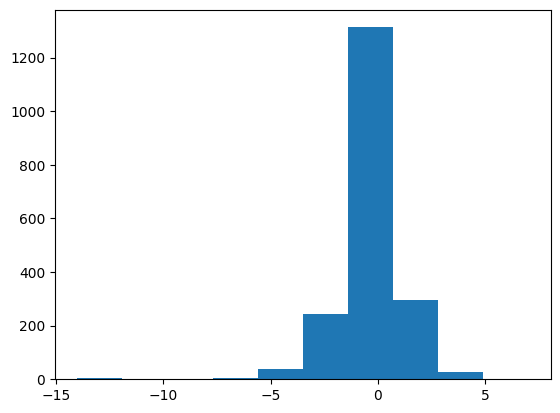

In [261]:
plt.hist([ud['deltas'][0] for ud in uttid_and_deltas])

[Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '6'),
 Text(0, 0, '14'),
 Text(0, 0, '23'),
 Text(0, 0, '64'),
 Text(0, 0, '180'),
 Text(0, 0, '431'),
 Text(0, 0, '882'),
 Text(0, 0, '236'),
 Text(0, 0, '61'),
 Text(0, 0, '21'),
 Text(0, 0, '5'),
 Text(0, 0, '1'),
 Text(0, 0, '1')]

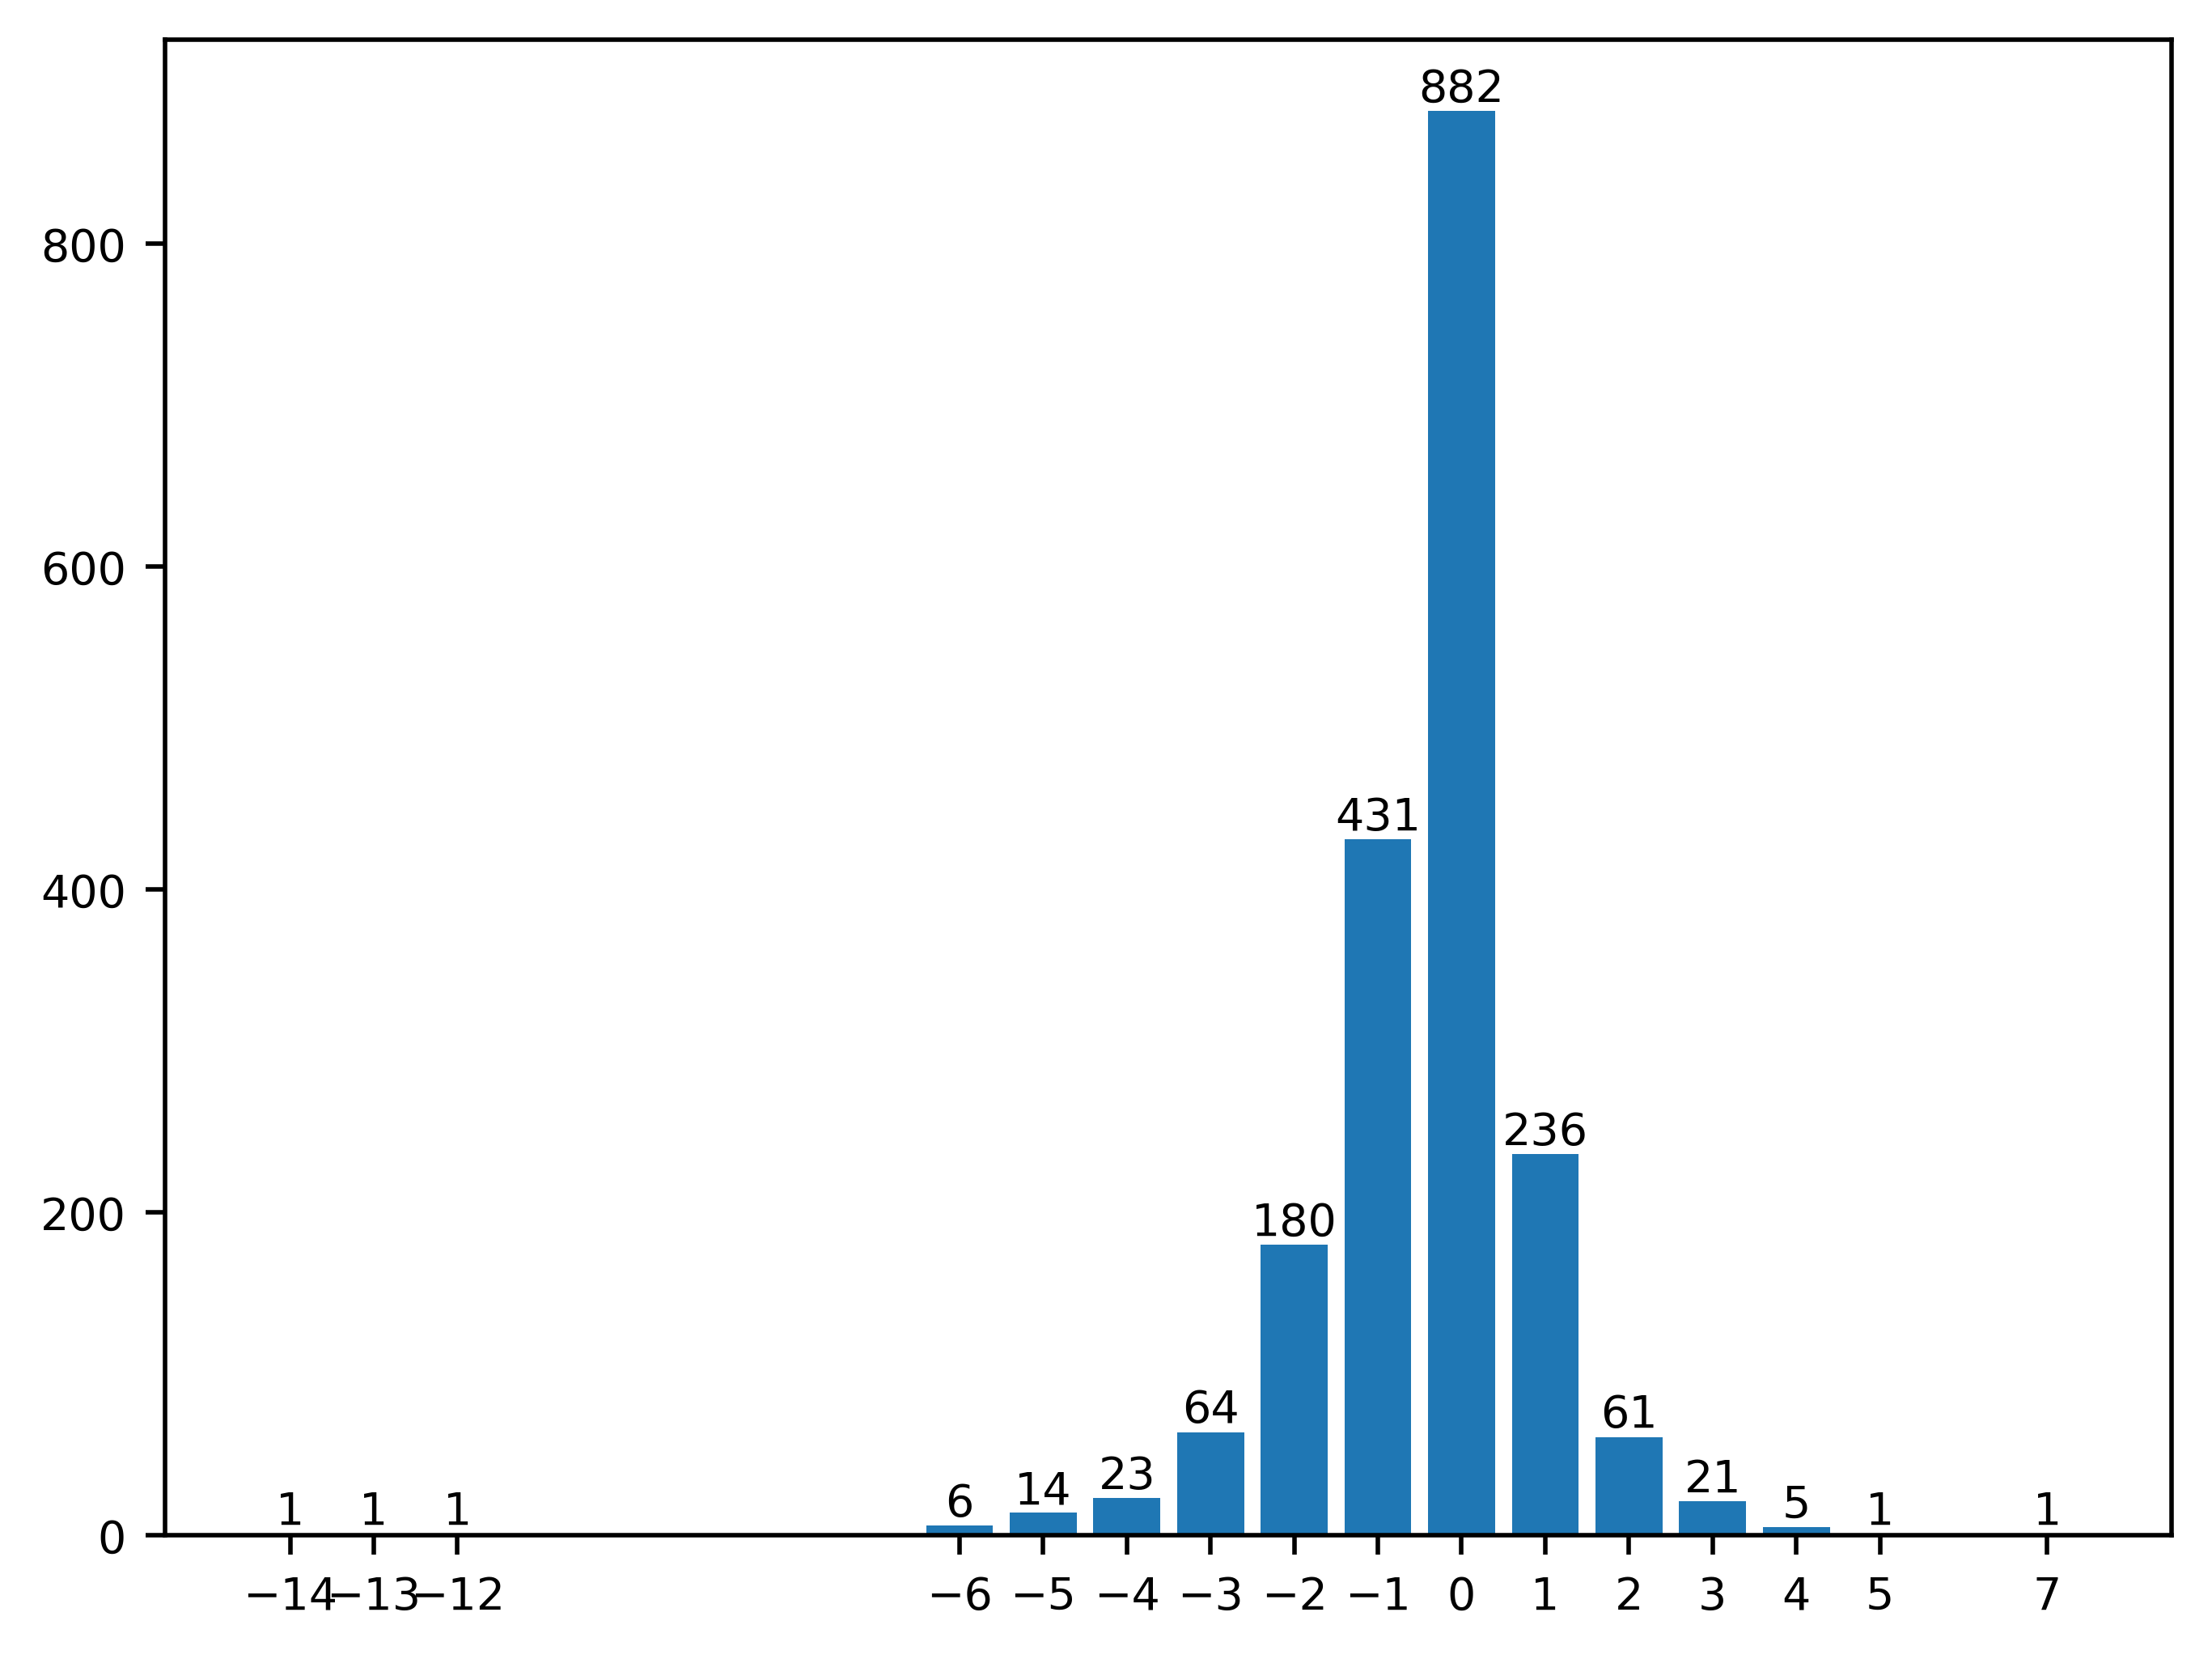

In [346]:
from collections import Counter
wdeltas = Counter([ud['edit_deltas'][0] for ud in uttid_and_deltas])
fig, ax = plt.subplots()
bars = ax.bar(wdeltas.keys(), wdeltas.values())
ax.xaxis.set_ticks(list(wdeltas.keys()))
ax.bar_label(bars)


[Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '317'),
 Text(0, 0, '8'),
 Text(0, 0, '115'),
 Text(0, 0, '21'),
 Text(0, 0, '6'),
 Text(0, 0, '2'),
 Text(0, 0, '209'),
 Text(0, 0, '1'),
 Text(0, 0, '1155'),
 Text(0, 0, '22'),
 Text(0, 0, '63'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '4'),
 Text(0, 0, '1')]

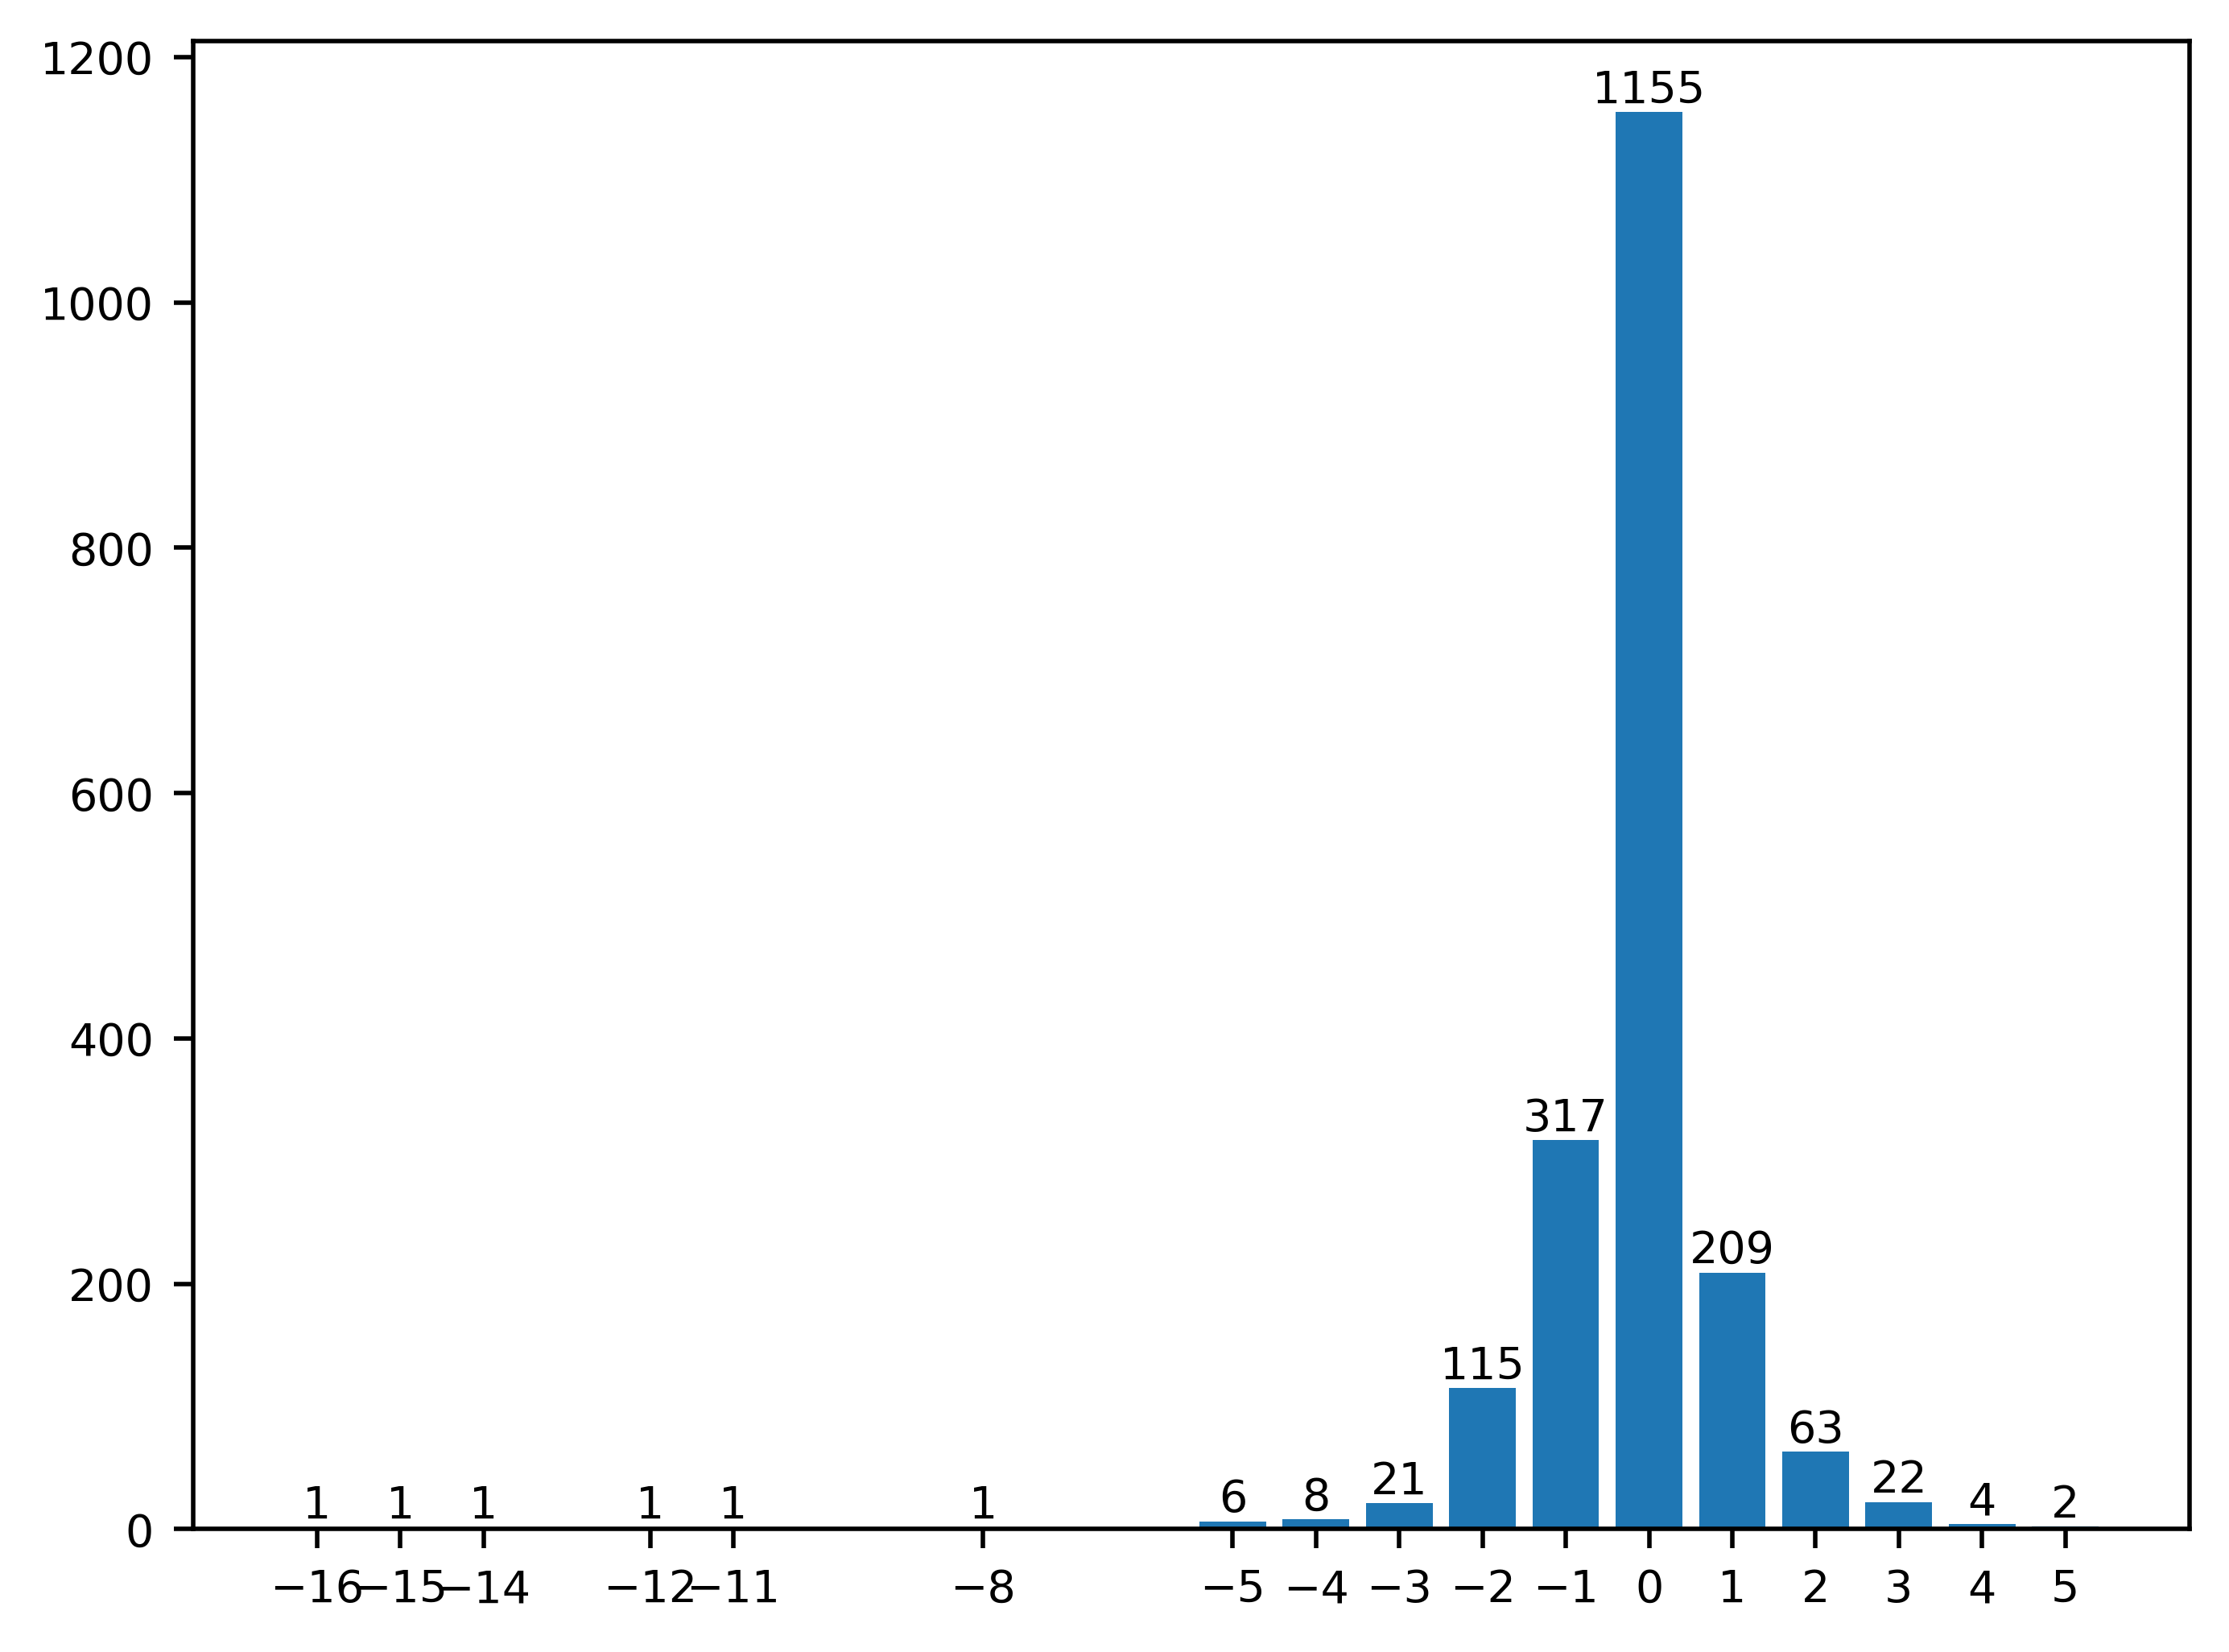

In [347]:
from collections import Counter
wdeltas = Counter([ud['edit_deltas'][2] for ud in uttid_and_deltas])
fig, ax = plt.subplots()
bars = ax.bar(wdeltas.keys(), wdeltas.values())
ax.xaxis.set_ticks(list(wdeltas.keys()))
ax.bar_label(bars)

In [303]:
sum(delta*hits for delta, hits in wdeltas.items() if (delta<-0) )

-1220

In [291]:
sum(delta*hits for delta, hits in wdeltas.items() if (delta>1) )

217

[Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '4'),
 Text(0, 0, '28'),
 Text(0, 0, '46'),
 Text(0, 0, '4'),
 Text(0, 0, '10'),
 Text(0, 0, '1'),
 Text(0, 0, '11'),
 Text(0, 0, '108'),
 Text(0, 0, '30'),
 Text(0, 0, '5'),
 Text(0, 0, '60'),
 Text(0, 0, '66'),
 Text(0, 0, '53'),
 Text(0, 0, '47'),
 Text(0, 0, '1'),
 Text(0, 0, '4'),
 Text(0, 0, '123'),
 Text(0, 0, '63'),
 Text(0, 0, '15'),
 Text(0, 0, '27'),
 Text(0, 0, '1'),
 Text(0, 0, '726'),
 Text(0, 0, '172'),
 Text(0, 0, '105'),
 Text(0, 0, '16'),
 Text(0, 0, '65'),
 Text(0, 0, '6'),
 Text(0, 0, '1'),
 Text(0, 0, '18'),
 Text(0, 0, '47'),
 Text(0, 0, '1'),
 Text(0, 0, '9'),
 Text(0, 0, '8'),
 Text(0, 0, '11'),
 Text(0, 0, '1'),
 Text(0, 0, '10'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '2'),
 Text(0, 0, '2'),
 Text(0, 0, '5'),
 Text(0, 0, '2'),
 Text(0, 0, '2'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '1')]

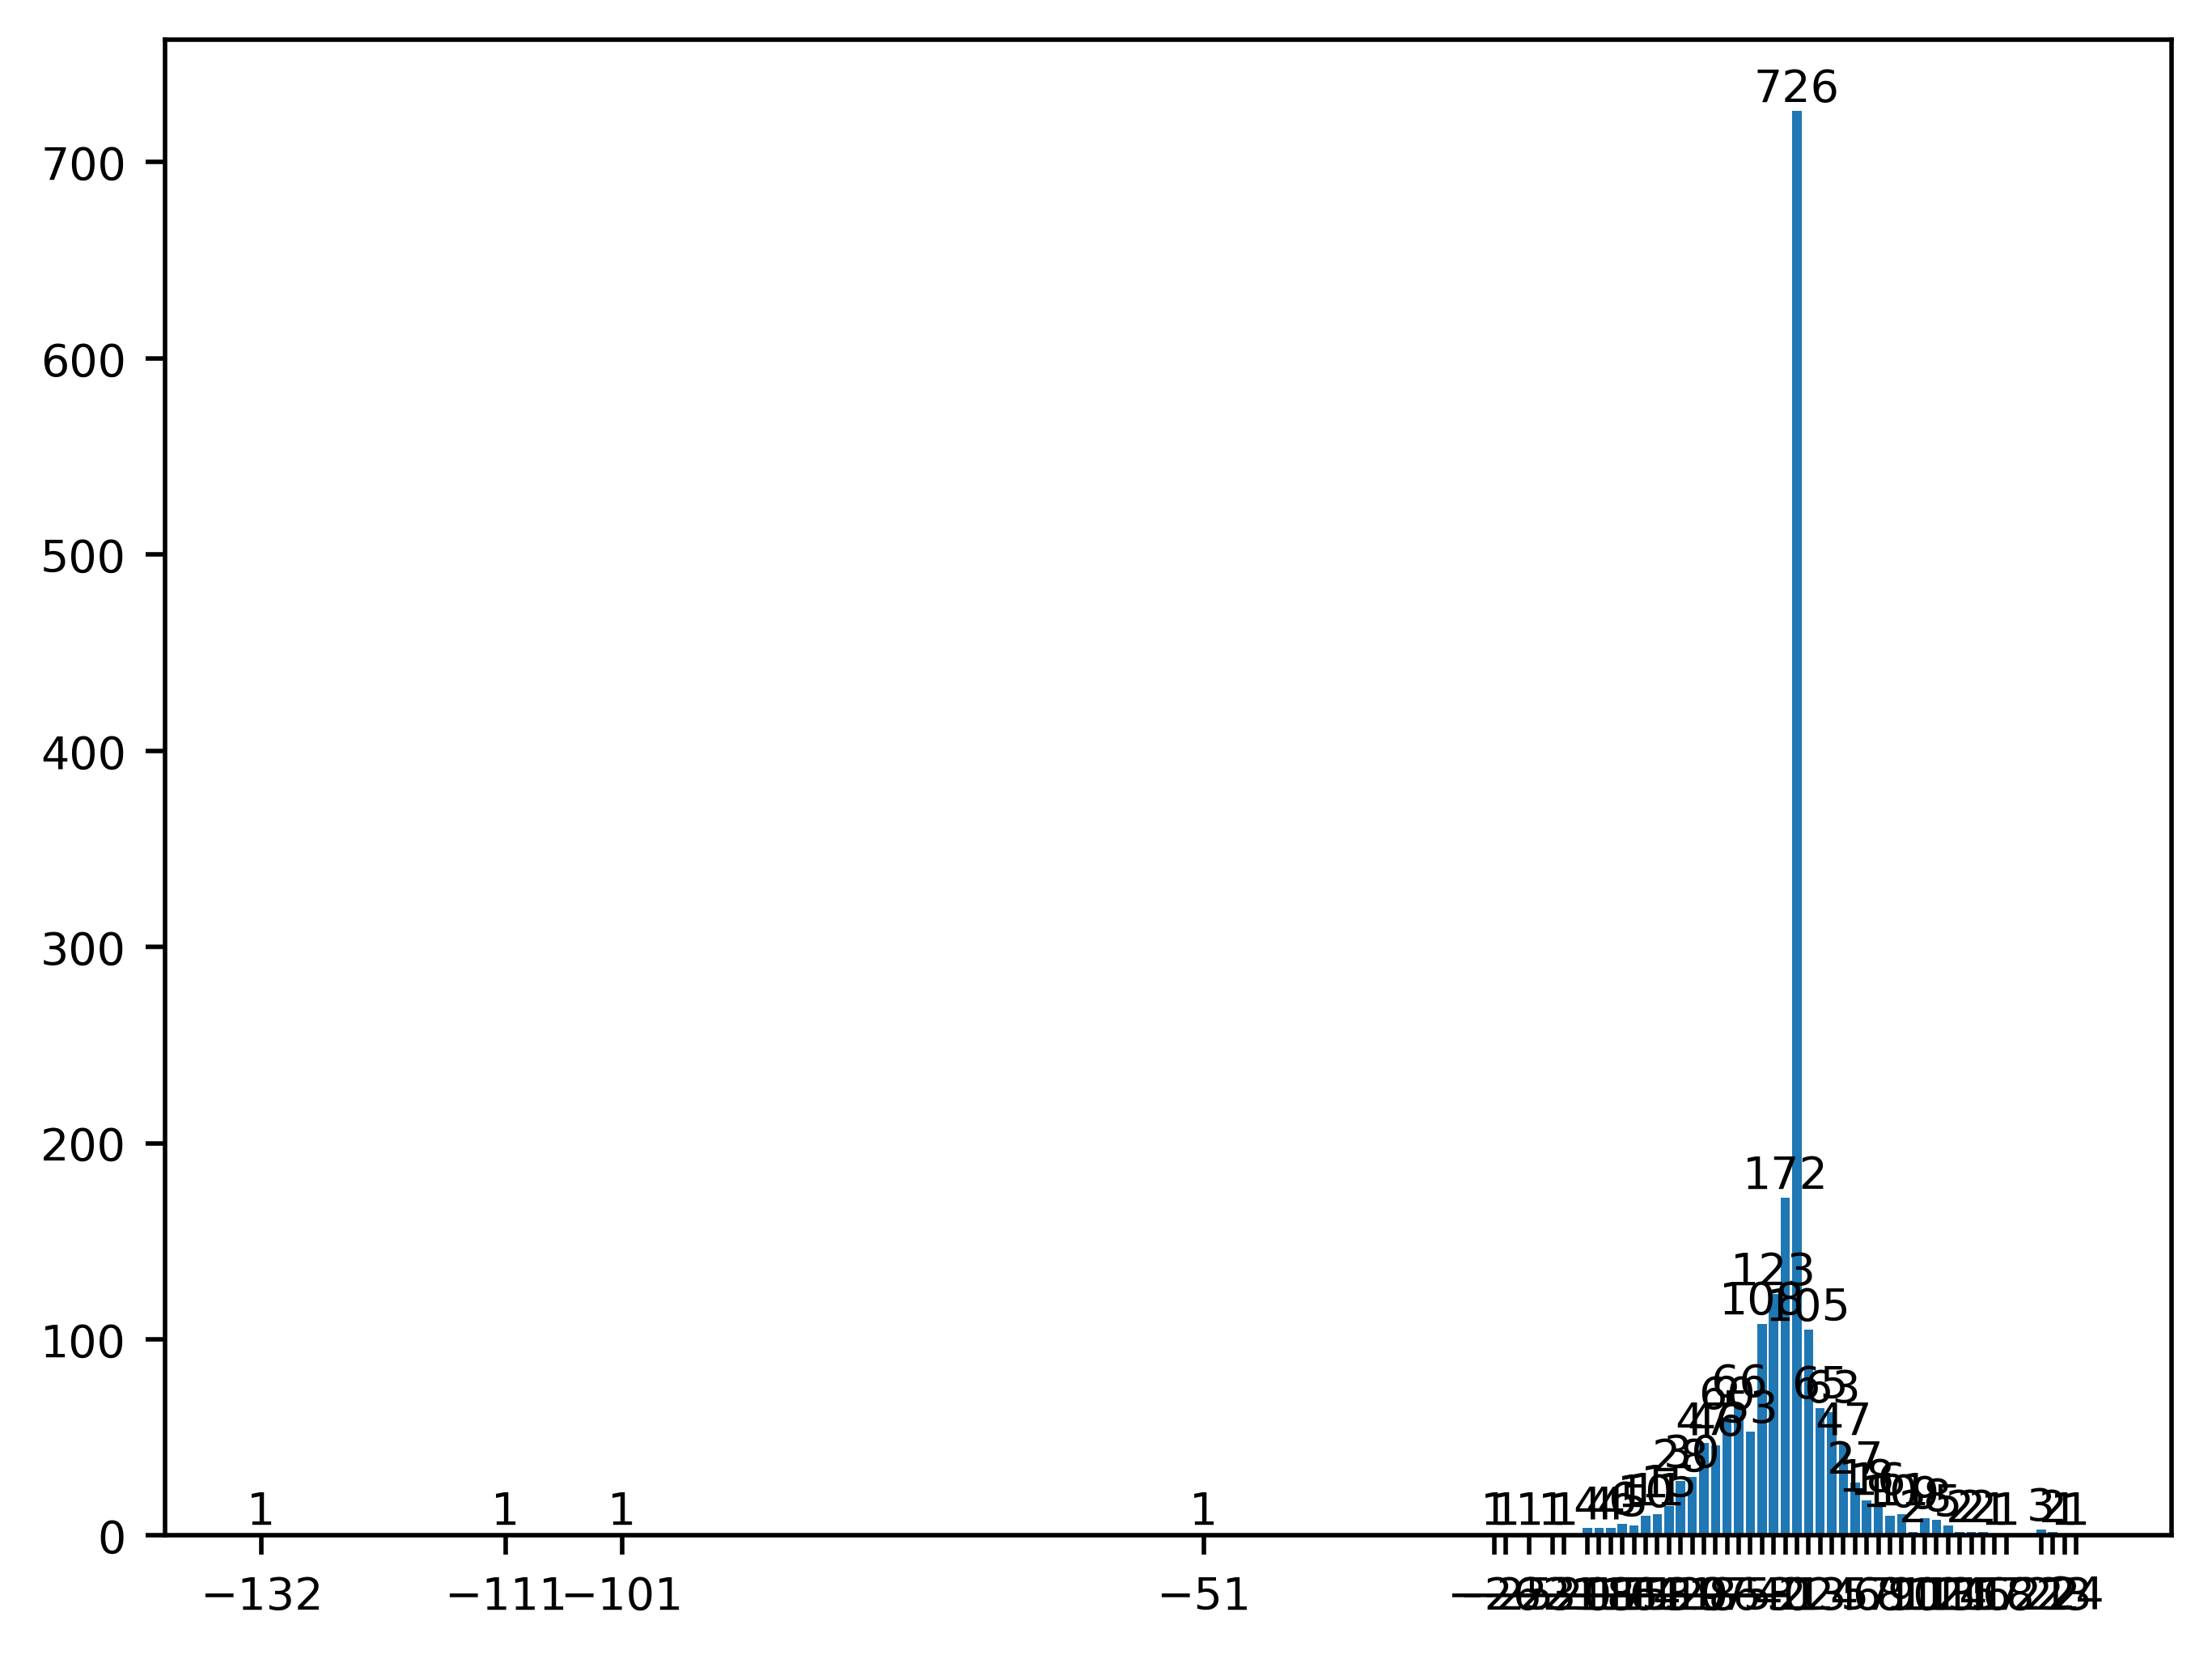

In [275]:
plt.rcParams.update({'font.size': 8})
plt.rcParams['figure.dpi'] = 500
cdeltas = Counter([ud['deltas'][1] for ud in uttid_and_deltas])
fig, ax = plt.subplots()
bars = ax.bar(cdeltas.keys(), cdeltas.values())
ax.xaxis.set_ticks(list(cdeltas.keys()))
ax.bar_label(bars)

In [298]:
uttid_and_deltas_by_wer = sorted(uttid_and_deltas, key= lambda x: x['rate_deltas'][0])

In [299]:
for ud in uttid_and_deltas_by_wer[:10]:
    print(ud['key'])
    print("Word Edit delta:", ud['edit_deltas'][0])
    print("Char Edit delta:", ud['edit_deltas'][1])
    print("WER delta:", ud['rate_deltas'][0])
    print("CER delta:", ud['rate_deltas'][1])
    print()
    print("REF:", ud['hmm_variants'][0]['ref_tokens'])
    print("HMM:", ud['hmm_variants'][0]['hyp_tokens'])
    print("AED:", ud['aed_variants'][0]['hyp_tokens'])
    print()

sampo-terho-01028
Word Edit delta: -2
Char Edit delta: -9
WER delta: -100.0
CER delta: -56.25

REF: ['vastaan', 'lyhyesti']
HMM: ['vastaan', 'lyhyesti']
AED: ['lyhyestä']

reijo-laitinen-00841
Word Edit delta: -1
Char Edit delta: -1
WER delta: -100.0
CER delta: -7.6923076923076925

REF: ['vaikutuksista']
HMM: ['vaikutuksista']
AED: ['vaikutuksesta']

ville-tavio-00386
Word Edit delta: -13
Char Edit delta: -101
WER delta: -92.85714285714286
CER delta: -87.06896551724138

REF: ['sain', 'tuosta', 'lähteestä', 'sen', 'lähteestäni', 'sen', 'käsityksen', 'että', 'tämä', 'vanhenemisaika', 'on', 'yhdysvalloissakin', 'pidemmästä', 'päästä']
HMM: ['sain', 'tuosta', 'lähteestä', 'lähteestäni', 'sen', 'käsityksen', 'että', 'tämä', 'vanhenemisaika', 'on', 'yhdysvalloissakin', 'pidemmästä', 'päästä']
AED: ['arvoisa', 'puhemies']

sampo-terho-01030
Word Edit delta: -14
Char Edit delta: -111
WER delta: -73.6842105263158
CER delta: -69.375

REF: ['siitä', 'ei', 'huolehdita', 'tempputyöllistämällä', 'ei

In [301]:
for ud in uttid_and_deltas_by_wer[-10:]:
    print(ud['key'])
    print("Word Edit delta:", ud['edit_deltas'][0])
    print("Char Edit delta:", ud['edit_deltas'][1])
    print("WER delta:", ud['rate_deltas'][0])
    print("CER delta:", ud['rate_deltas'][1])
    print()
    print("REF:", ud['hmm_variants'][0]['ref_tokens'])
    print("HMM:", ud['hmm_variants'][0]['hyp_tokens'])
    print("AED:", ud['aed_variants'][0]['hyp_tokens'])
    print()

pekka-vilkuna-00451
Word Edit delta: 1
Char Edit delta: 5
WER delta: 33.333333333333336
CER delta: 23.80952380952381

REF: ['ihmiskunta', 'tekee', 'itse']
HMM: ['ihmiskunta', 'tekee']
AED: ['ihmiskunta', 'tekee', 'itse']

pekka-vilkuna-00474
Word Edit delta: 1
Char Edit delta: 1
WER delta: 33.333333333333336
CER delta: 3.5714285714285716

REF: ['edustaja', 'urpilaisen', 'kuulevan']
HMM: ['edustaja', 'urpilaisen', 'kuuleman']
AED: ['edustaja', 'urpilaisen', 'kuulevan']

matti-saarinen-06470
Word Edit delta: 2
Char Edit delta: 9
WER delta: 33.333333333333336
CER delta: 17.64705882352941

REF: ['sivu', 'nelkytyks', 'siellä', 'on', 'valiokunnan', 'lausumaehdotus']
HMM: ['sivun', 'neljäkymmentäyksi', 'jolloin', 'valiokunnan', 'lausumaehdotus']
AED: ['sivunelägetyyksi', 'siellä', 'on', 'valiokunnan', 'lausumaehdotus']

pekka-vilkuna-00487
Word Edit delta: 2
Char Edit delta: 1
WER delta: 33.333333333333336
CER delta: 2.5641025641025643

REF: ['koko', 'päivä', 'on', 'keskusteltu', 'tästä', 'as

(array([3.000e+00, 2.000e+00, 2.000e+01, 4.100e+01, 6.550e+02, 1.188e+03,
        1.400e+01, 3.000e+00, 1.000e+00, 1.000e+00]),
 array([-100.,  -80.,  -60.,  -40.,  -20.,    0.,   20.,   40.,   60.,
          80.,  100.]),
 <BarContainer object of 10 artists>)

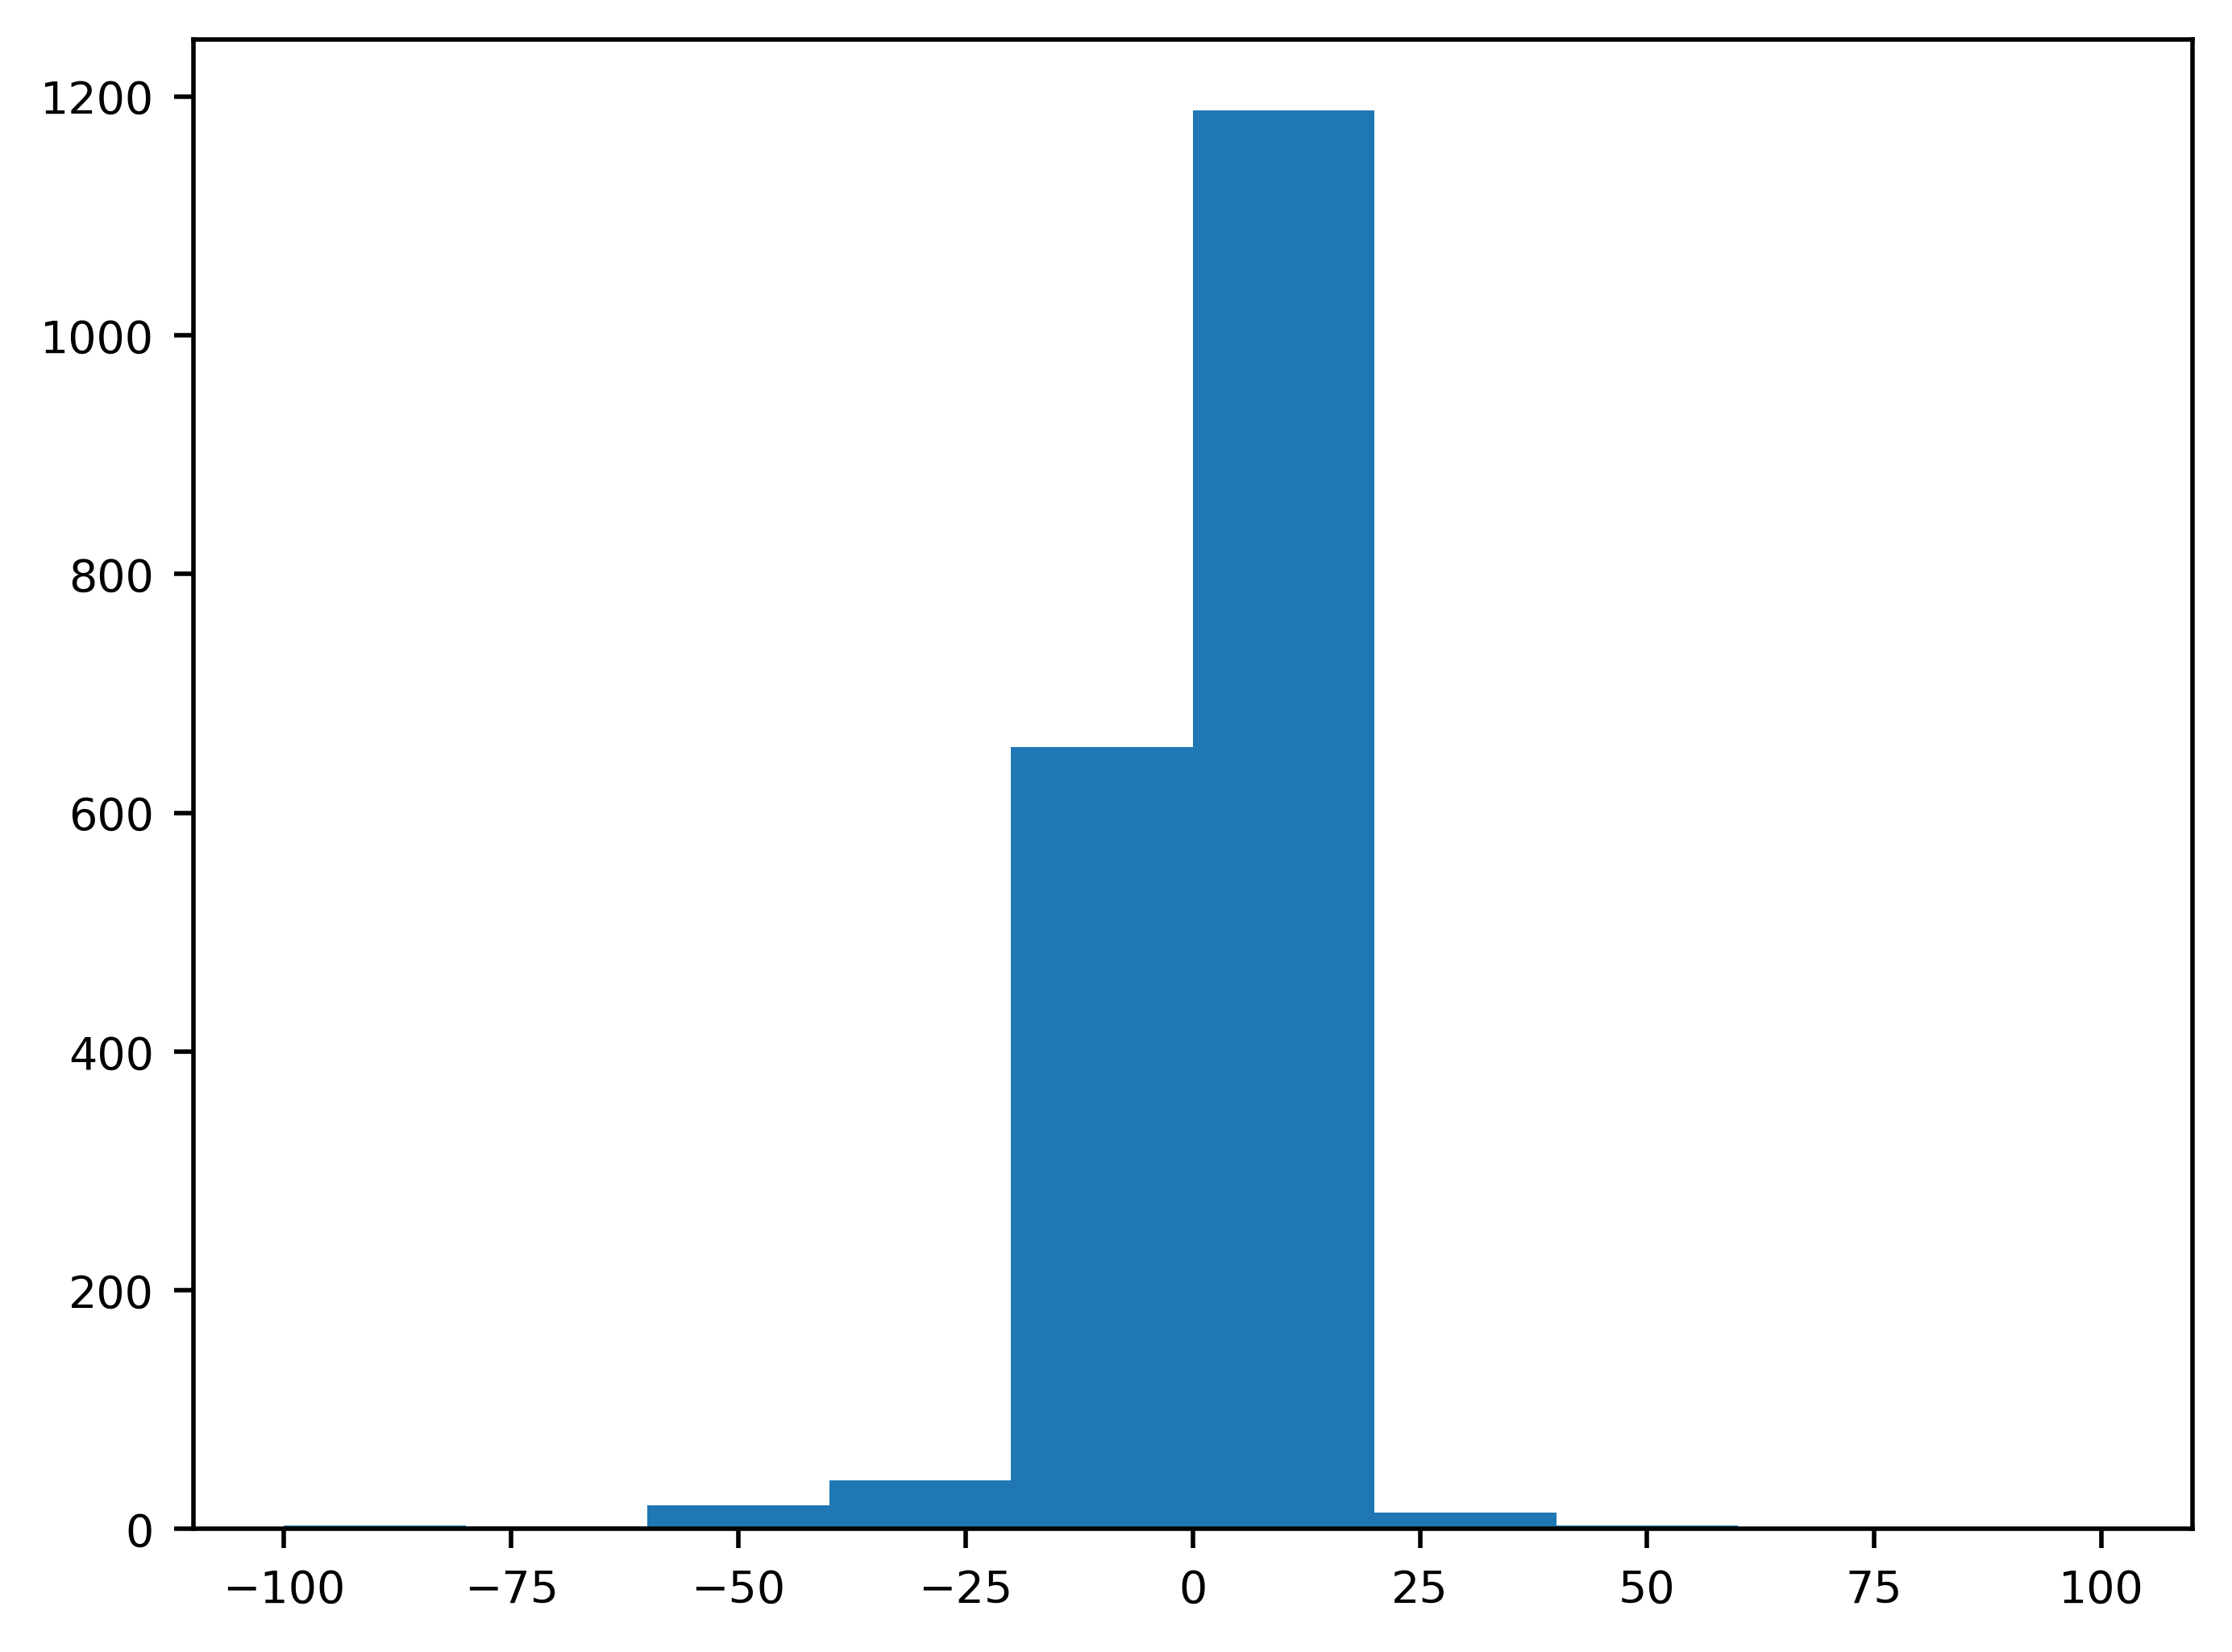

In [300]:
plt.hist([ud['rate_deltas'][0] for ud in uttid_and_deltas])

In [411]:
hmm_ops, aed_ops, cross_ops = analyse_edit_ops(test_ref, hmm_crdnn_trans_hyp, aed_crdnn_trans_hyp)

In [412]:
printed = 0
common_hmm = Counter()
for (edit, r, h), times in hmm_ops.most_common():
    if edit != "=":
        print(r, edit, h, times)
        printed+=1
        common_hmm[(edit,r,h)] = times
    if printed == 30:
        break
    

ja D <eps> 114
että D <eps> 91
niin D <eps> 66
<eps> I ja 47
on D <eps> 33
kuin D <eps> 28
tää S tämä 22
on S ovat 18
<eps> I on 18
edustaja D <eps> 13
tuota D <eps> 11
tai D <eps> 10
ei S eivät 10
<eps> I niin 9
mä S minä 9
<eps> I arvoisa 8
<eps> I että 8
tän S tämän 8
myös D <eps> 7
tulee S tulevat 7
vaan S vain 7
se D <eps> 6
<eps> I nyt 6
kuin S kun 6
<eps> I se 6
ne D <eps> 5
kun S kuin 5
mielestä S mielestäni 5
edustaja S arvoisa 5
jos D <eps> 5


In [413]:
printed = 0
common_aed = Counter()
for (edit, r, h), times in aed_ops.most_common():
    if edit != "=":
        print(r, edit, h, times)
        printed+=1
        common_aed[(edit, r, h)] = times
    if printed == 30:
        break
    

ja D <eps> 102
niin D <eps> 102
että D <eps> 74
<eps> I ja 43
on D <eps> 43
kuin D <eps> 30
<eps> I on 27
tää S tämä 24
on S ovat 19
edustaja D <eps> 17
<eps> I että 16
se D <eps> 12
ei D <eps> 12
ne D <eps> 11
tuota D <eps> 11
myös D <eps> 10
mä S minä 10
vaan S vain 8
kuin S kun 8
kun S kuin 7
arvoisa D <eps> 7
sen D <eps> 7
sitten D <eps> 7
tai D <eps> 7
<eps> I niin 7
tän S tämän 7
sitä D <eps> 6
<eps> I sitten 6
tämä D <eps> 6
no D <eps> 5


In [414]:
sum(edit in common_hmm for edit in common_aed)

22

In [418]:
printed = 0
common_cross = Counter()
for (edit, r, h), times in cross_ops.most_common():
    if edit != "=":
        print(r, edit, h, times)
        printed+=1
        common_cross[(edit, r, h)] = times
    if printed == 30:
        break
    

<eps> I ja 73
niin D <eps> 66
ja D <eps> 60
<eps> I että 35
on D <eps> 35
<eps> I on 35
<eps> I niin 23
että D <eps> 16
arvoisa D <eps> 15
se D <eps> 14
ei D <eps> 10
<eps> I nyt 8
<eps> I se 7
myös D <eps> 7
<eps> I tai 7
ole D <eps> 6
nyt D <eps> 6
sitten D <eps> 6
<eps> I kuin 6
on S ovat 5
<eps> I sen 5
kuin D <eps> 5
me D <eps> 5
kuin S kun 5
tätä D <eps> 4
tulevat S tulee 4
kun S kuin 4
ovat D <eps> 4
en D <eps> 4
vaan S vain 4


In [392]:
hmm_ops, aed_ops, cross_ops = analyse_edit_ops(test_ref_char, hmm_crdnn_trans_hyp_char, aed_crdnn_trans_hyp_char)

In [393]:
printed = 0
common_hmm = Counter()
for (edit, r, h), times in hmm_ops.most_common():
    if edit != "=":
        print(r, edit, h, times)
        printed+=1
        common_hmm[(edit,r,h)] = times
    if printed == 75:
        break

  D <eps> 733
n D <eps> 509
t D <eps> 421
<eps> I   420
i D <eps> 411
<eps> I a 397
a D <eps> 396
<eps> I n 351
<eps> I t 335
<eps> I i 330
e D <eps> 299
<eps> I e 260
ä D <eps> 226
<eps> I s 191
s D <eps> 173
j D <eps> 160
<eps> I ä 142
u D <eps> 139
<eps> I o 137
<eps> I m 133
<eps> I u 128
<eps> I l 125
o D <eps> 118
k D <eps> 110
<eps> I v 100
l D <eps> 98
<eps> I k 92
<eps> I j 88
<eps> I h 68
i S e 67
m D <eps> 57
e S i 53
<eps> I r 53
v D <eps> 42
<eps> I y 42
h D <eps> 38
y D <eps> 37
d D <eps> 37
a S i 32
r D <eps> 30
a S e 29
a S ä 27
<eps> I p 26
<eps> I d 25
ä S a 23
p D <eps> 22
n S v 21
a S o 21
ö D <eps> 20
e S ä 20
i S a 20
a S m 20
e S v 18
e S a 17
u S o 17
ä S e 16
t S n 16
<eps> I ö 15
n S l 13
o S a 13
n S m 13
t S s 12
i S ä 12
t S l 12
n S a 11
n S s 11
m S n 10
o S u 10
t S m 10
n S t 9
i S t 9
u S a 9
y S i 9
ä S m 9
i S u 8


In [394]:
printed = 0
common_aed = Counter()
for (edit, r, h), times in aed_ops.most_common():
    if edit != "=":
        print(r, edit, h, times)
        printed+=1
        common_aed[(edit,r,h)] = times
    if printed == 75:
        break

  D <eps> 1075
n D <eps> 889
i D <eps> 770
a D <eps> 688
t D <eps> 605
e D <eps> 500
<eps> I   431
s D <eps> 346
ä D <eps> 334
<eps> I n 323
<eps> I a 305
o D <eps> 277
u D <eps> 272
<eps> I t 262
l D <eps> 259
<eps> I i 256
k D <eps> 215
j D <eps> 178
<eps> I e 176
m D <eps> 156
<eps> I s 128
<eps> I ä 127
<eps> I o 109
h D <eps> 101
r D <eps> 98
i S e 96
<eps> I m 91
v D <eps> 87
<eps> I l 82
<eps> I j 81
y D <eps> 69
<eps> I u 69
d D <eps> 65
e S i 63
<eps> I k 60
p D <eps> 60
<eps> I v 56
a S ä 38
<eps> I h 37
ö D <eps> 36
<eps> I y 34
ä S a 33
e S ä 33
<eps> I r 33
e S a 33
a S e 32
ä S e 32
i S a 28
a S i 27
n S v 25
o S a 21
a S o 18
u S o 17
m S n 17
<eps> I d 16
a S m 15
l S n 14
n S s 14
n S m 14
i S t 14
t S n 13
<eps> I ö 13
<eps> I p 13
o S u 12
u S a 12
i S u 12
i S ä 12
m S v 11
n S a 11
s S n 11
a S u 10
e S v 10
d S r 10
y S i 10
t S s 10


In [395]:
printed = 0
common_cross = Counter()
for (edit, r, h), times in cross_ops.most_common():
    if edit != "=":
        print(r, edit, h, times)
        printed+=1
        common_cross[(edit,r,h)] = times
    if printed == 75:
        break

  D <eps> 774
n D <eps> 679
i D <eps> 649
a D <eps> 617
t D <eps> 453
<eps> I   444
e D <eps> 415
s D <eps> 316
<eps> I n 283
l D <eps> 257
o D <eps> 256
ä D <eps> 251
u D <eps> 239
<eps> I a 223
<eps> I i 190
<eps> I t 185
k D <eps> 178
m D <eps> 162
<eps> I e 148
<eps> I ä 137
j D <eps> 116
h D <eps> 115
v D <eps> 112
r D <eps> 99
<eps> I j 93
<eps> I s 80
<eps> I o 76
i S e 76
e S i 69
y D <eps> 62
p D <eps> 62
<eps> I u 49
<eps> I l 45
<eps> I k 44
d D <eps> 41
e S a 38
ö D <eps> 33
i S a 28
a S ä 28
ä S e 27
ä S a 26
o S a 25
e S ä 24
<eps> I m 24
a S e 21
<eps> I y 20
<eps> I h 19
<eps> I v 19
o S u 17
s S n 16
n S a 16
l S n 15
a S i 15
<eps> I r 15
n S t 14
t S n 13
n S i 13
m S n 13
s S t 13
u S o 12
i S j 11
i S t 11
a S u 10
<eps> I ö 10
o S e 10
n S l 10
i S y 10
v S m 10
<eps> I p 10
i S   10
i S ä 10
a S o 10
<eps> I d 9
t S s 9
i S u 9


In [403]:
hmm_edit_streaks, aed_edit_streaks = analyse_edit_streaks(test_ref, hmm_crdnn_trans_hyp, aed_crdnn_trans_hyp)

[Text(0, 0, '1691'),
 Text(0, 0, '423'),
 Text(0, 0, '79'),
 Text(0, 0, '3'),
 Text(0, 0, '17'),
 Text(0, 0, '2'),
 Text(0, 0, '1')]

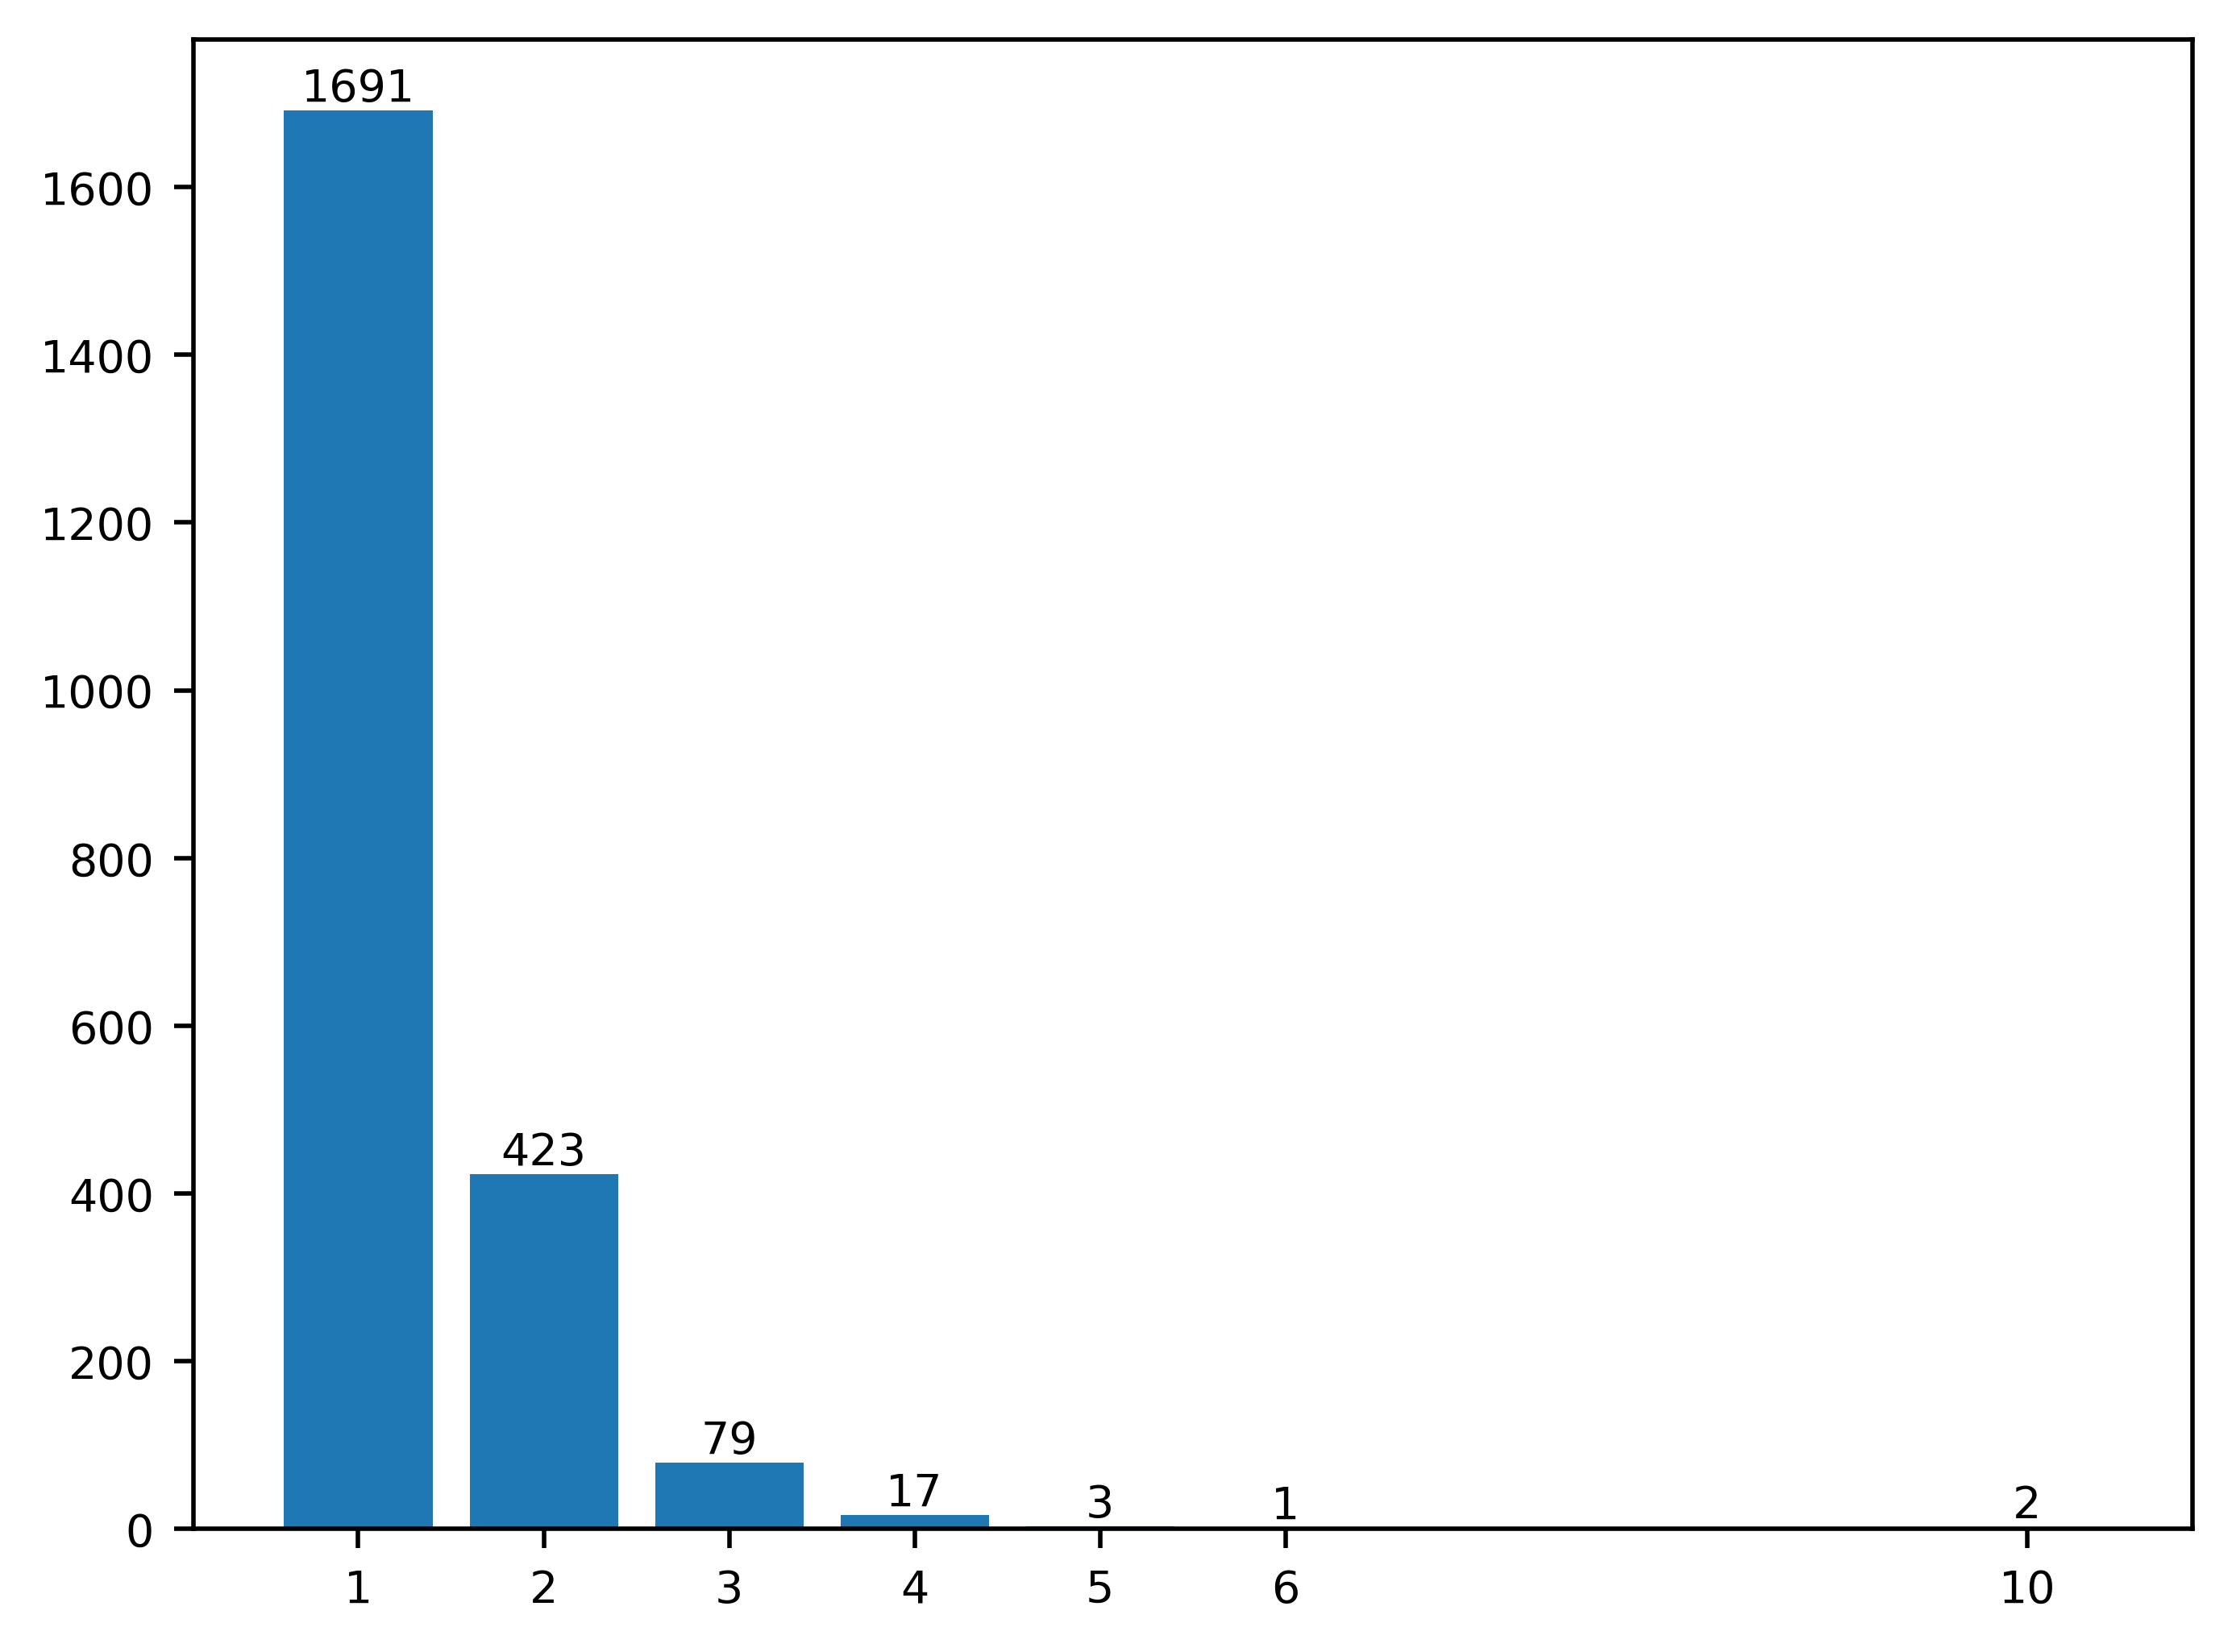

In [405]:
fig, ax = plt.subplots()
bars = ax.bar(hmm_edit_streaks.keys(), hmm_edit_streaks.values())
ax.xaxis.set_ticks(list(hmm_edit_streaks.keys()))
ax.bar_label(bars)

[Text(0, 0, '1982'),
 Text(0, 0, '572'),
 Text(0, 0, '112'),
 Text(0, 0, '25'),
 Text(0, 0, '5'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '2')]

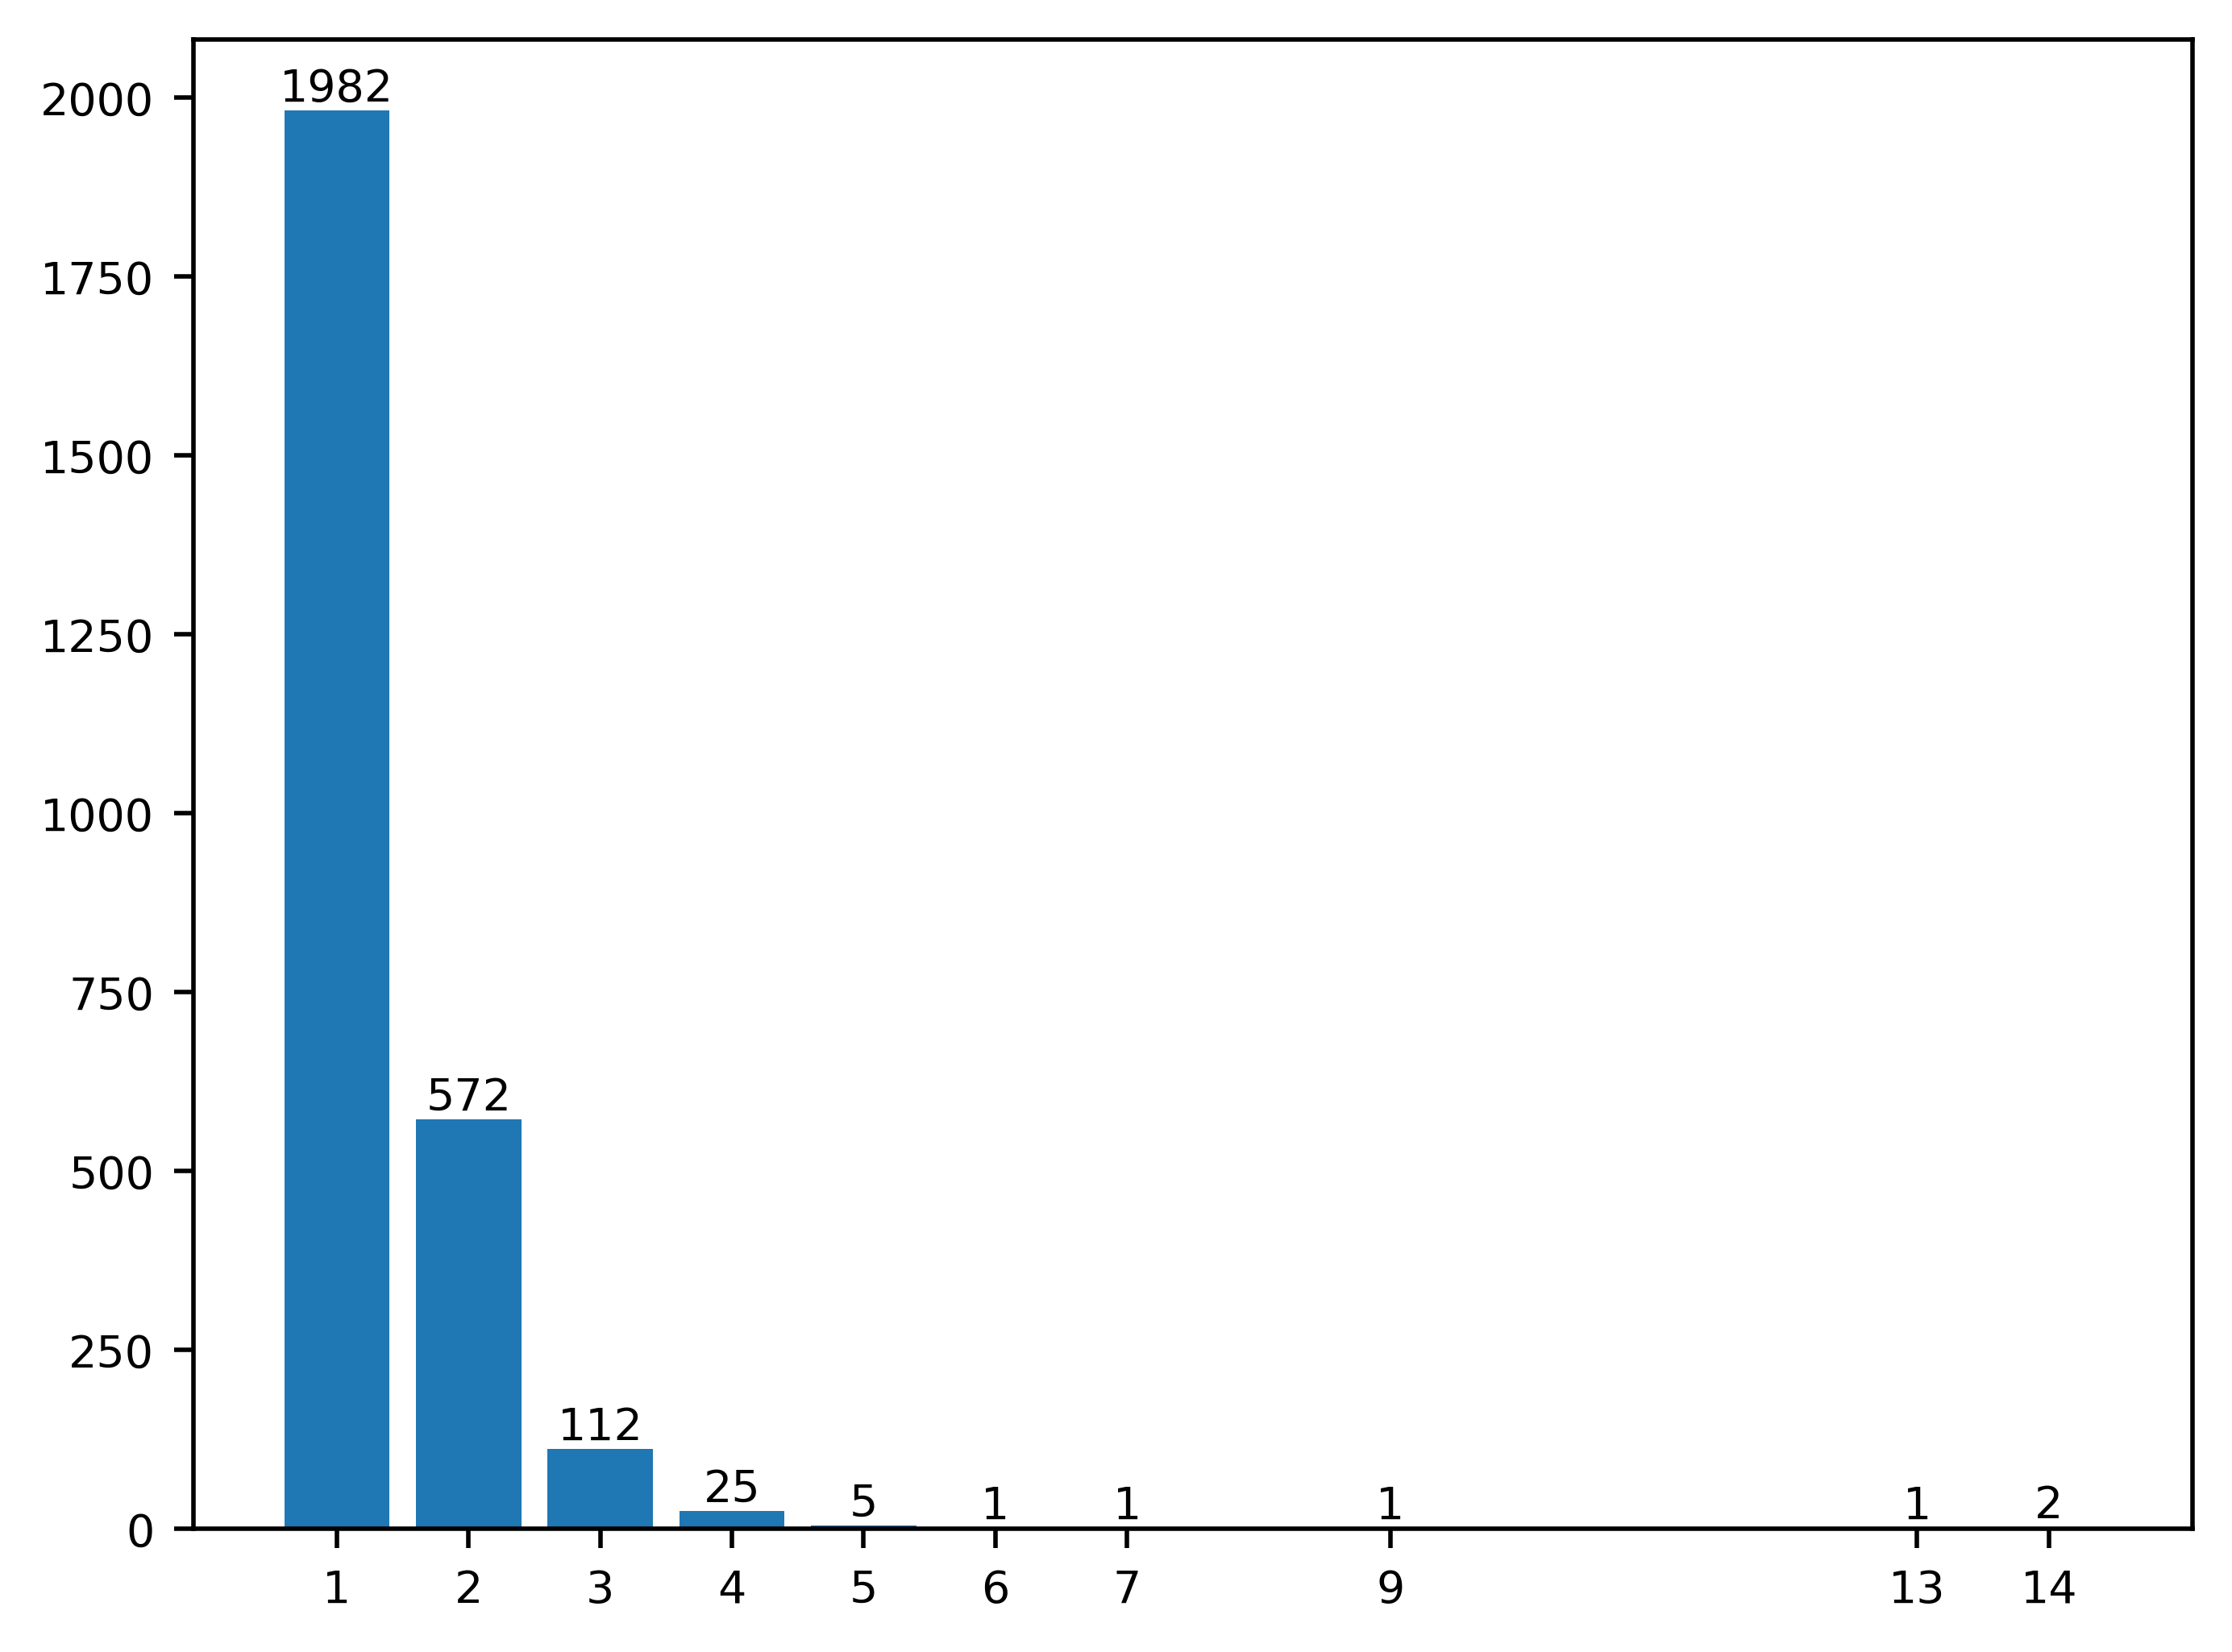

In [406]:
fig, ax = plt.subplots()
bars = ax.bar(aed_edit_streaks.keys(), aed_edit_streaks.values())
ax.xaxis.set_ticks(list(aed_edit_streaks.keys()))
ax.bar_label(bars)

## Librispeech

In [309]:
test_ref_path = "librispeech/exp/chain/New-CRDNN-FF-10-fixed-contd/2602-2256units/decode_test_clean_bpe.5000.varikn_acwt1.0/scoring_kaldi/test_filt.txt"
hmm_crdnn_trans_hyp_path = "librispeech/exp/chain/New-CRDNN-FF-10-fixed-contd/2602-2256units/decode_test_clean_bpe.5000.varikn_acwt1.0/scoring_kaldi/penalty_0.5/10.txt"
aed_crdnn_trans_hyp_path = "librispeech/exp/attention/CRDNN-FF-10-contd/2602-5000units/text_test_clean_beam8_cov3.0_eos1.3_temp1.5_noattnshift.txt"


test_ref = load_text(test_ref_path)

test_ref_char = load_chars(test_ref_path)

hmm_crdnn_trans_hyp = load_text(hmm_crdnn_trans_hyp_path)

hmm_crdnn_trans_hyp_char = load_chars(hmm_crdnn_trans_hyp_path)

aed_crdnn_trans_hyp = load_text(aed_crdnn_trans_hyp_path)

aed_crdnn_trans_hyp_char = load_chars(aed_crdnn_trans_hyp_path)

utt2spk = {uttid: "-".join(uttid.split("-")[:-1]) for uttid in test_ref}

In [310]:
analyse_basic(test_ref, hmm_crdnn_trans_hyp, aed_crdnn_trans_hyp, utt2spk)

HMM Summary:
%WER 4.59 [ 2411 / 52576, 222 ins, 250 del, 1939 sub ]
%SER 45.53 [ 1193 / 2620 ]
Scored 2620 sentences, 0 not present in hyp.
SPEAKERS WITH HIGHEST WER
lbi-5142-36586 %WER 14.29
lbi-8555-292519 %WER 10.84
lbi-8463-294825 %WER 9.66
lbi-1995-1836 %WER 9.39
lbi-4992-41797 %WER 9.30

AED Summary:
%WER 5.11 [ 2685 / 52576, 345 ins, 227 del, 2113 sub ]
%SER 47.71 [ 1250 / 2620 ]
Scored 2620 sentences, 0 not present in hyp.
SPEAKERS WITH HIGHEST WER
lbi-8463-294825 %WER 13.40
lbi-8555-284447 %WER 12.43
lbi-7176-92135 %WER 11.46
lbi-4446-2271 %WER 10.89
lbi-1995-1836 %WER 10.77

That leaves an edit delta of -274
Which is -0.10458015267175573 delta per utterance

144 utts in common
out of 250 top WER utterances
That is 57.599999999999994 %

2 speakers in common
out of 5 top WER speakers
That is 40.0 %
Are the top WER speakers the same?
HMM: ['lbi-5142-36586', 'lbi-8555-292519', 'lbi-8463-294825', 'lbi-1995-1836', 'lbi-4992-41797']
AED: ['lbi-8463-294825', 'lbi-8555-284447', 'lbi-7

In [312]:
analyse_basic(test_ref_char, hmm_crdnn_trans_hyp_char, aed_crdnn_trans_hyp_char, utt2spk)

HMM Summary:
%WER 1.60 [ 4511 / 281530, 1342 ins, 1392 del, 1777 sub ]
%SER 45.53 [ 1193 / 2620 ]
Scored 2620 sentences, 0 not present in hyp.
SPEAKERS WITH HIGHEST WER
lbi-5142-36586 %WER 5.64
lbi-2961-961 %WER 3.86
lbi-7176-92135 %WER 3.48
lbi-8555-284447 %WER 3.47
lbi-4992-41806 %WER 3.24

AED Summary:
%WER 1.89 [ 5326 / 281530, 1434 ins, 1745 del, 2147 sub ]
%SER 47.71 [ 1250 / 2620 ]
Scored 2620 sentences, 0 not present in hyp.
SPEAKERS WITH HIGHEST WER
lbi-4077-13751 %WER 5.87
lbi-8555-284447 %WER 4.73
lbi-2961-961 %WER 4.45
lbi-7176-92135 %WER 4.27
lbi-260-123286 %WER 4.06

That leaves an edit delta of -815
Which is -0.3110687022900763 delta per utterance

134 utts in common
out of 250 top WER utterances
That is 53.6 %

3 speakers in common
out of 5 top WER speakers
That is 60.0 %
Are the top WER speakers the same?
HMM: ['lbi-5142-36586', 'lbi-2961-961', 'lbi-7176-92135', 'lbi-8555-284447', 'lbi-4992-41806']
AED: ['lbi-4077-13751', 'lbi-8555-284447', 'lbi-2961-961', 'lbi-7176-92

In [313]:
uttid_and_deltas = analyse_deltas_multi(
    [test_ref, test_ref_char], 
    [hmm_crdnn_trans_hyp, hmm_crdnn_trans_hyp_char], 
    [aed_crdnn_trans_hyp, aed_crdnn_trans_hyp_char])

In [314]:
for ud in uttid_and_deltas[-10:]:
    print(ud['key'])
    print("Word Edit delta:", ud['edit_deltas'][0])
    print("Char Edit delta:", ud['edit_deltas'][1])
    print("WER delta:", ud['rate_deltas'][0])
    print("CER delta:", ud['rate_deltas'][1])
    print()
    print("REF:", ud['hmm_variants'][0]['ref_tokens'])
    print("HMM:", ud['hmm_variants'][0]['hyp_tokens'])
    print("AED:", ud['aed_variants'][0]['hyp_tokens'])
    print()

lbi-5142-36586-0003
Word Edit delta: 4
Char Edit delta: 9
WER delta: 23.529411764705884
CER delta: 9.375

REF: ['BUT', 'THIS', 'SUBJECT', 'WILL', 'BE', 'MORE', 'PROPERLY', 'DISCUSSED', 'WHEN', 'WE', 'TREAT', 'OF', 'THE', 'DIFFERENT', 'RACES', 'OF', 'MANKIND']
HMM: ['BUT', 'THIS', 'SUBJECT', 'WILL', 'BE', 'MORE', 'PROPERLY', 'DISCUSSED', 'WILL', 'RETREAT', 'OF', 'DIFFERENT', 'RACES', 'OF', 'MANKIND']
AED: ['BUT', 'THIS', 'SUBJECT', 'WILL', 'BE', 'MORE', 'PROPERLY', 'DISCUSSED', 'WHEN', 'WE', 'TREAT', 'OF', 'THE', 'DIFFERENT', 'RACES', 'OF', 'MANKIND']

lbi-7176-88083-0001
Word Edit delta: 4
Char Edit delta: 4
WER delta: 9.75609756097561
CER delta: 1.7241379310344829

REF: ['THE', 'MERGANSER', 'HAD', 'A', 'CRESTED', 'HEAD', 'OF', 'IRIDESCENT', 'GREEN', 'BLACK', 'A', 'BROAD', 'COLLAR', 'OF', 'LUSTROUS', 'WHITE', 'BLACK', 'BACK', 'BLACK', 'AND', 'WHITE', 'WINGS', 'WHITE', 'BELLY', 'SIDES', 'FINELY', 'PENCILLED', 'IN', 'BLACK', 'AND', 'WHITE', 'AND', 'A', 'BREAST', 'OF', 'RICH', 'CHESTNUT',

In [315]:
for ud in uttid_and_deltas[:10]:
    print(ud['key'])
    print("Word Edit delta:", ud['edit_deltas'][0])
    print("Char Edit delta:", ud['edit_deltas'][1])
    print("WER delta:", ud['rate_deltas'][0])
    print("CER delta:", ud['rate_deltas'][1])
    print()
    print("REF:", ud['hmm_variants'][0]['ref_tokens'])
    print("HMM:", ud['hmm_variants'][0]['hyp_tokens'])
    print("AED:", ud['aed_variants'][0]['hyp_tokens'])
    print()

lbi-4077-13751-0018
Word Edit delta: -27
Char Edit delta: -162
WER delta: -42.1875
CER delta: -45.50561797752809

REF: ['AMERICAN', 'SCHOOL', 'BOYS', 'READ', 'WITH', 'EMOTIONS', 'OF', 'HORROR', 'OF', 'THE', 'ALBIGENSES', 'DRIVEN', 'BEATEN', 'AND', 'KILLED', 'WITH', 'A', 'PAPAL', 'LEGATE', 'DIRECTING', 'THE', 'BUTCHERY', 'AND', 'OF', 'THE', 'VAUDOIS', 'HUNTED', 'AND', 'HOUNDED', 'LIKE', 'BEASTS', 'AS', 'THE', 'EFFECT', 'OF', 'A', 'ROYAL', 'DECREE', 'AND', 'THEY', 'YET', 'SHALL', 'READ', 'IN', 'THE', 'HISTORY', 'OF', 'THEIR', 'OWN', 'COUNTRY', 'OF', 'SCENES', 'AS', 'TERRIBLE', 'AS', 'THESE', 'IN', 'THE', 'EXHIBITION', 'OF', 'INJUSTICE', 'AND', 'INHUMAN', 'HATE']
HMM: ['AMERICAN', 'SCHOOLBOYS', 'READ', 'WITH', 'EMOTIONS', 'OF', 'HORROR', 'OF', 'THE', "ALBAGINS'S", 'DRIVEN', 'BEATEN', 'AND', 'KILLED', 'WITH', 'A', 'PAPAL', 'LEGATE', 'DIRECTING', 'THE', 'BUTCHERY', 'AND', 'OF', 'THE', 'VAUDOIS', 'HUNTED', 'AND', 'HOUNDED', 'LIKE', 'BEASTS', 'AS', 'THE', 'EFFECT', 'OF', 'A', 'ROYAL', 'DECREE